# COMP1801 - Machine Learning Coursework Solution

Let’s start by importing the essential Python libraries for data analysis and machine learning.

In [25]:
# Import libraries
try:
    import glob
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Importing libraries for model building
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import Ridge
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import cross_val_score

    from statsmodels.stats.outliers_influence import variance_inflation_factor

except Exception as e:
    print(f"Error : {e}")

## Data Exploration and Initial Analysis

The first stage involves performing a comprehensive exploration of the dataset. The main objective of this phase is to identify relationships and patterns in the data and justify the selection of features for modeling. Initial observations from the lifespan distributions across different part types indicate variability, with certain types (e.g., Blocks) exhibiting longer lifespans compared to others like Blades and Valves. To support a more detailed feature selection, correlation matrices will be calculated to understand the linear dependencies between numerical features and `Lifespan`. For categorical features like `partType`, `microstructure`, and `castType`, visualizations such as boxplots will be employed to analyze how these features impact the lifespan. This phase aims to establish the basis for selecting meaningful predictors for regression and classification.

### Load the dataset

First, we will load the dataset into a pandas DataFrame by lazy loading the CSV file.

In [26]:
# Find the CSV file in the Datasets directory
data_path = '../Datasets/*.csv'
file_list = glob.glob(data_path)

for file in file_list:
    print(f"Found file: {file}")

# Ensure there is exactly one file
if len(file_list) == 1:
    # Load the dataset
    df = pd.read_csv(file_list[0])
    print(f"Loaded dataset: {file_list[0]}")
else:
    raise FileNotFoundError("No CSV file found or multiple CSV files found in the Datasets directory.")

Found file: ../Datasets/COMP1801_Coursework_Dataset.csv
Loaded dataset: ../Datasets/COMP1801_Coursework_Dataset.csv


**Code Explanation**: `glob.glob(data_path)` returns a list of file paths matching the pattern `'Datasets/*.csv'`. The code checks if there is exactly one file in the list. If there is exactly one file, it reads the CSV file into a DataFrame. If there are no files or more than one file, it raises an error. This approach ensures that you can dynamically find and read the single CSV file in the `Datasets` directory without needing to specify the filename manually.



In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lifespan        1000 non-null   float64
 1   partType        1000 non-null   object 
 2   microstructure  1000 non-null   object 
 3   coolingRate     1000 non-null   int64  
 4   quenchTime      1000 non-null   float64
 5   forgeTime       1000 non-null   float64
 6   HeatTreatTime   1000 non-null   float64
 7   Nickel%         1000 non-null   float64
 8   Iron%           1000 non-null   float64
 9   Cobalt%         1000 non-null   float64
 10  Chromium%       1000 non-null   float64
 11  smallDefects    1000 non-null   int64  
 12  largeDefects    1000 non-null   int64  
 13  sliverDefects   1000 non-null   int64  
 14  seedLocation    1000 non-null   object 
 15  castType        1000 non-null   object 
dtypes: float64(8), int64(4), object(4)
memory usage: 125.1+ KB


In [36]:
# Check for missing values
df.isnull().sum()

Lifespan          0
partType          0
microstructure    0
coolingRate       0
quenchTime        0
forgeTime         0
HeatTreatTime     0
Nickel%           0
Iron%             0
Cobalt%           0
Chromium%         0
smallDefects      0
largeDefects      0
sliverDefects     0
seedLocation      0
castType          0
dtype: int64

In [27]:
df.head()

,Lifespan,partType,microstructure,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,largeDefects,sliverDefects,seedLocation,castType
0,1469.17,Nozzle,equiGrain,13,3.84,6.47,46.87,65.73,16.52,16.82,0.93,10,0,0,Bottom,Die
1,1793.64,Block,singleGrain,19,2.62,3.48,44.70,54.22,35.38,6.14,4.26,19,0,0,Bottom,Investment
2,700.60,Blade,equiGrain,28,0.76,1.34,9.54,51.83,35.95,8.81,3.41,35,3,0,Bottom,Investment
3,1082.10,Nozzle,colGrain,9,2.01,2.19,20.29,57.03,23.33,16.86,2.78,0,1,0,Top,Continuous
4,1838.83,Blade,colGrain,16,4.13,3.87,16.13,59.62,27.37,11.45,1.56,10,0,0,Top,Die


In [29]:
df.describe()

,Lifespan,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,largeDefects,sliverDefects
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1298.556320,17.639000,2.764230,5.464600,30.194510,60.243080,24.553580,12.434690,2.768650,17.311000,0.550000,0.292000
std,340.071434,7.491783,1.316979,2.604513,16.889415,5.790475,7.371737,4.333197,1.326496,12.268365,1.163982,1.199239
min,417.990000,5.000000,0.500000,1.030000,1.030000,50.020000,6.660000,5.020000,0.510000,0.000000,0.000000,0.000000
25%,1047.257500,11.000000,1.640000,3.170000,16.185000,55.287500,19.387500,8.597500,1.590000,7.000000,0.000000,0.000000
50%,1266.040000,18.000000,2.755000,5.475000,29.365000,60.615000,24.690000,12.585000,2.865000,18.000000,0.000000,0.000000
75%,1563.050000,24.000000,3.970000,7.740000,44.955000,65.220000,29.882500,16.080000,3.922500,26.000000,0.000000,0.000000
max,2134.530000,30.000000,4.990000,10.000000,59.910000,69.950000,43.650000,19.990000,4.990000,61.000000,4.000000,8.000000


In [30]:
# Using nunique()
num_parts = df['partType'].nunique()
print(f"Number of unique parts types: {num_parts}")

# Or using value_counts() to see the distribution
parts_distribution = df['partType'].value_counts()
print("\nDistribution of parts types:")
print(parts_distribution)

Number of unique parts types: 4

Distribution of parts types:
partType
Valve     265
Block     253
Nozzle    245
Blade     237
Name: count, dtype: int64


We have found that there are 4 disticnt metal parts in this dataset.

### Distribution of Lifespan

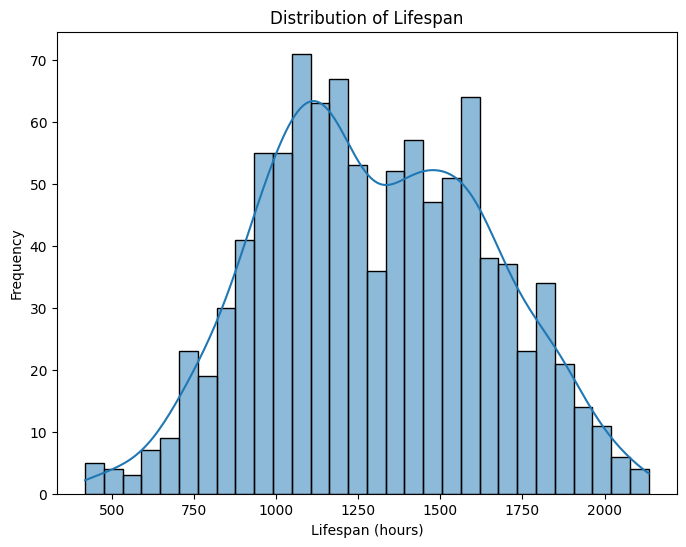

In [31]:
# Plotting the distribution of 'Lifespan'
plt.figure(figsize=(8, 6))
sns.histplot(df['Lifespan'], bins=30, kde=True)
plt.title('Distribution of Lifespan')
plt.xlabel('Lifespan (hours)')
plt.ylabel('Frequency')
plt.show()

#### Findings from Distribution of Lifespan

1. Distribution Shape and Symmetry

    - Observation: The histogram shows a roughly bell-shaped curve but with some irregularities, particularly towards the right side.

    - Skewness: The distribution does not appear to be perfectly symmetric. It seems to lean slightly towards the right (positive skew), as there are some high lifespan values stretching the tail on the right. This mild skewness suggests that while most metal parts have a lifespan concentrated around the central values, there are a few parts with significantly longer lifespans.

    - Implications: A right-skewed distribution indicates that the majority of the parts have a relatively shorter lifespan, with fewer parts achieving longer lifespans. This can reflect natural variations in part quality or durability and may suggest room for improvements in quality control.

2. Outliers and Extreme Values

    - Observation: There are a few lifespan values that appear on the far right, near or above $2000$ hours, which could be considered high-end outliers.

    - Implications:

        - Low outliers (if present) could indicate defective parts, while high outliers might represent exceptionally durable parts.

        - Such outliers may skew model predictions if not handled appropriately. Considering these extreme cases in the data preprocessing stage (e.g., with robust modeling techniques or by removing/transforming outliers) could enhance predictive model performance.

3. Need for Transformation

    - Observation: Due to the slight right skew, the data is not perfectly normal.

    - Implications for Modeling:

        - Applying a log transformation or Box-Cox transformation to the lifespan values might help normalize the distribution, making it more suitable for regression or machine learning models that benefit from normally distributed target variables.

        - Normalization can also reduce the influence of outliers on model parameters, leading to improved prediction accuracy and stability.

---

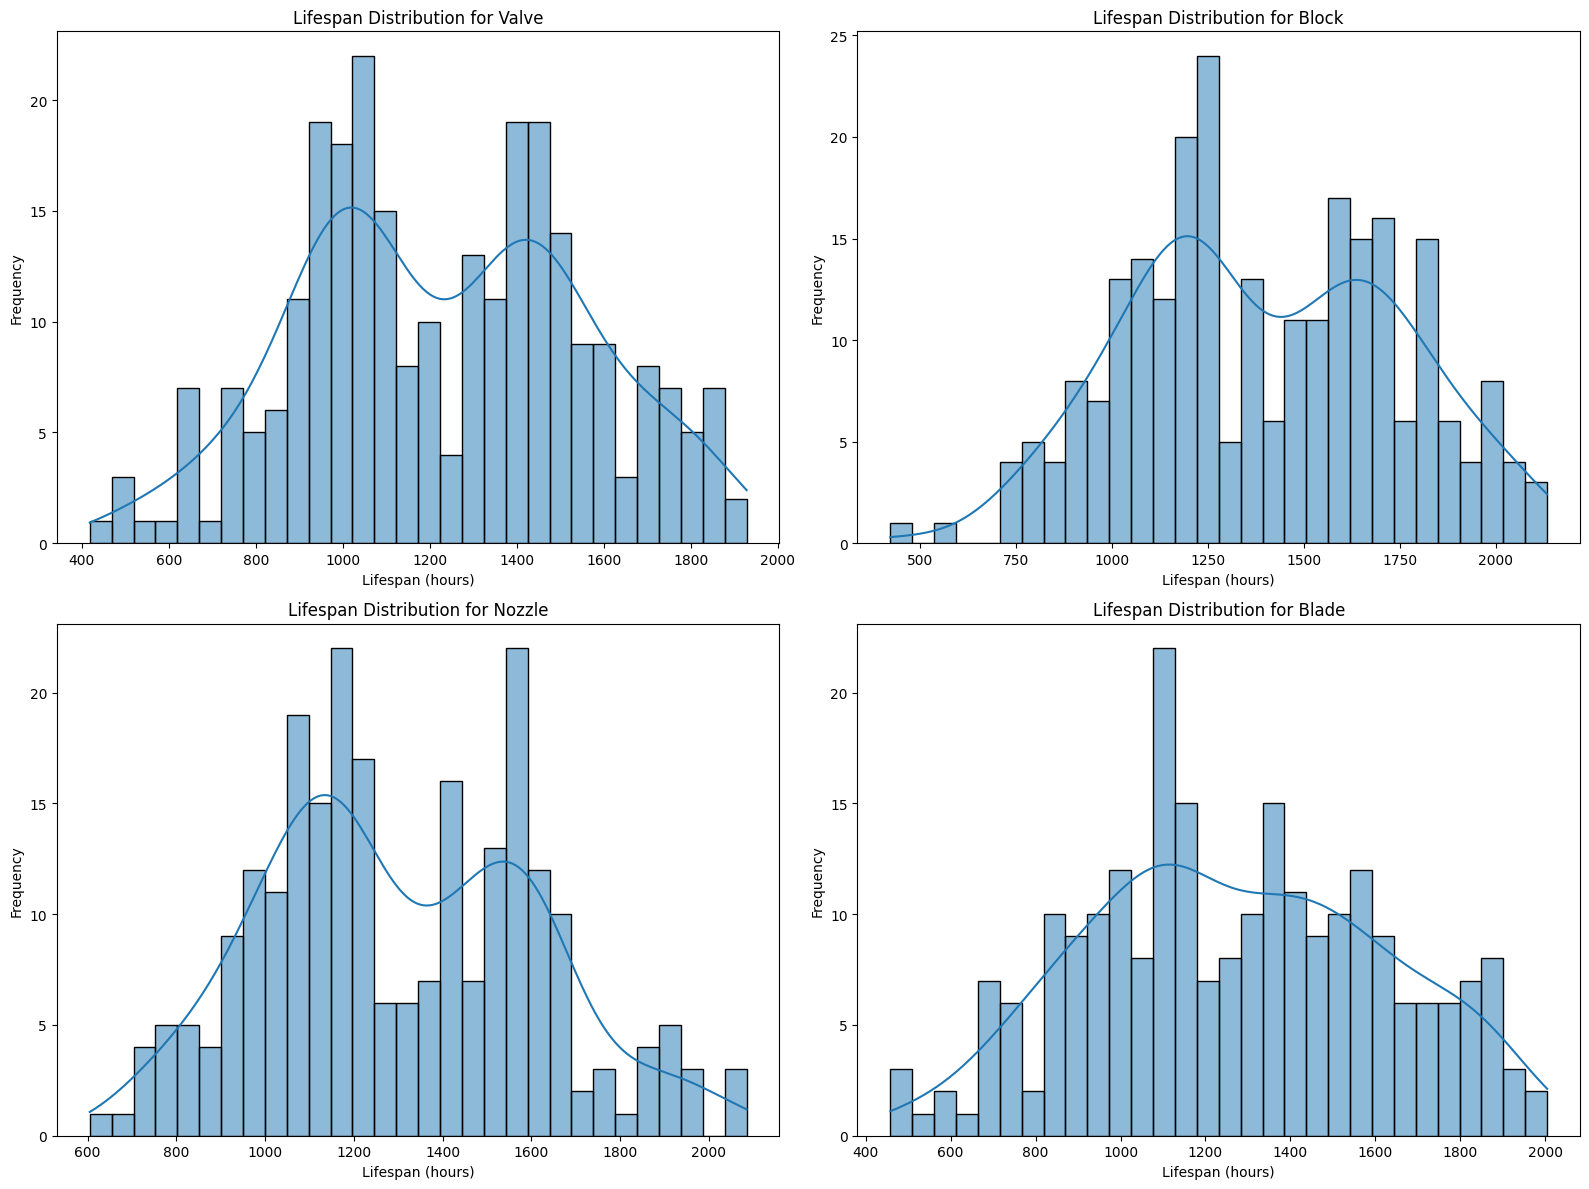

In [32]:
# List of metal parts
part_types = ['Valve', 'Block', 'Nozzle', 'Blade']

# Set up the subplots: 2 rows and 2 columns (one for each metal part)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Loop through each metal part and create a histogram for its lifespan distribution
for i, part in enumerate(part_types):
    subset = df[df['partType'] == part]
    sns.histplot(subset['Lifespan'], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Lifespan Distribution for {part}')
    axes[i].set_xlabel('Lifespan (hours)')
    axes[i].set_ylabel('Frequency')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

### Scatterplot analysis of numerical features with Lifespan

In [50]:
# List of numerical columns excluding 'Lifespan'
numerical_cols = ['coolingRate', 'quenchTime', 'forgeTime', 'HeatTreatTime',
                  'Nickel%', 'Iron%', 'Cobalt%', 'Chromium%',
                  'smallDefects', 'largeDefects', 'sliverDefects']

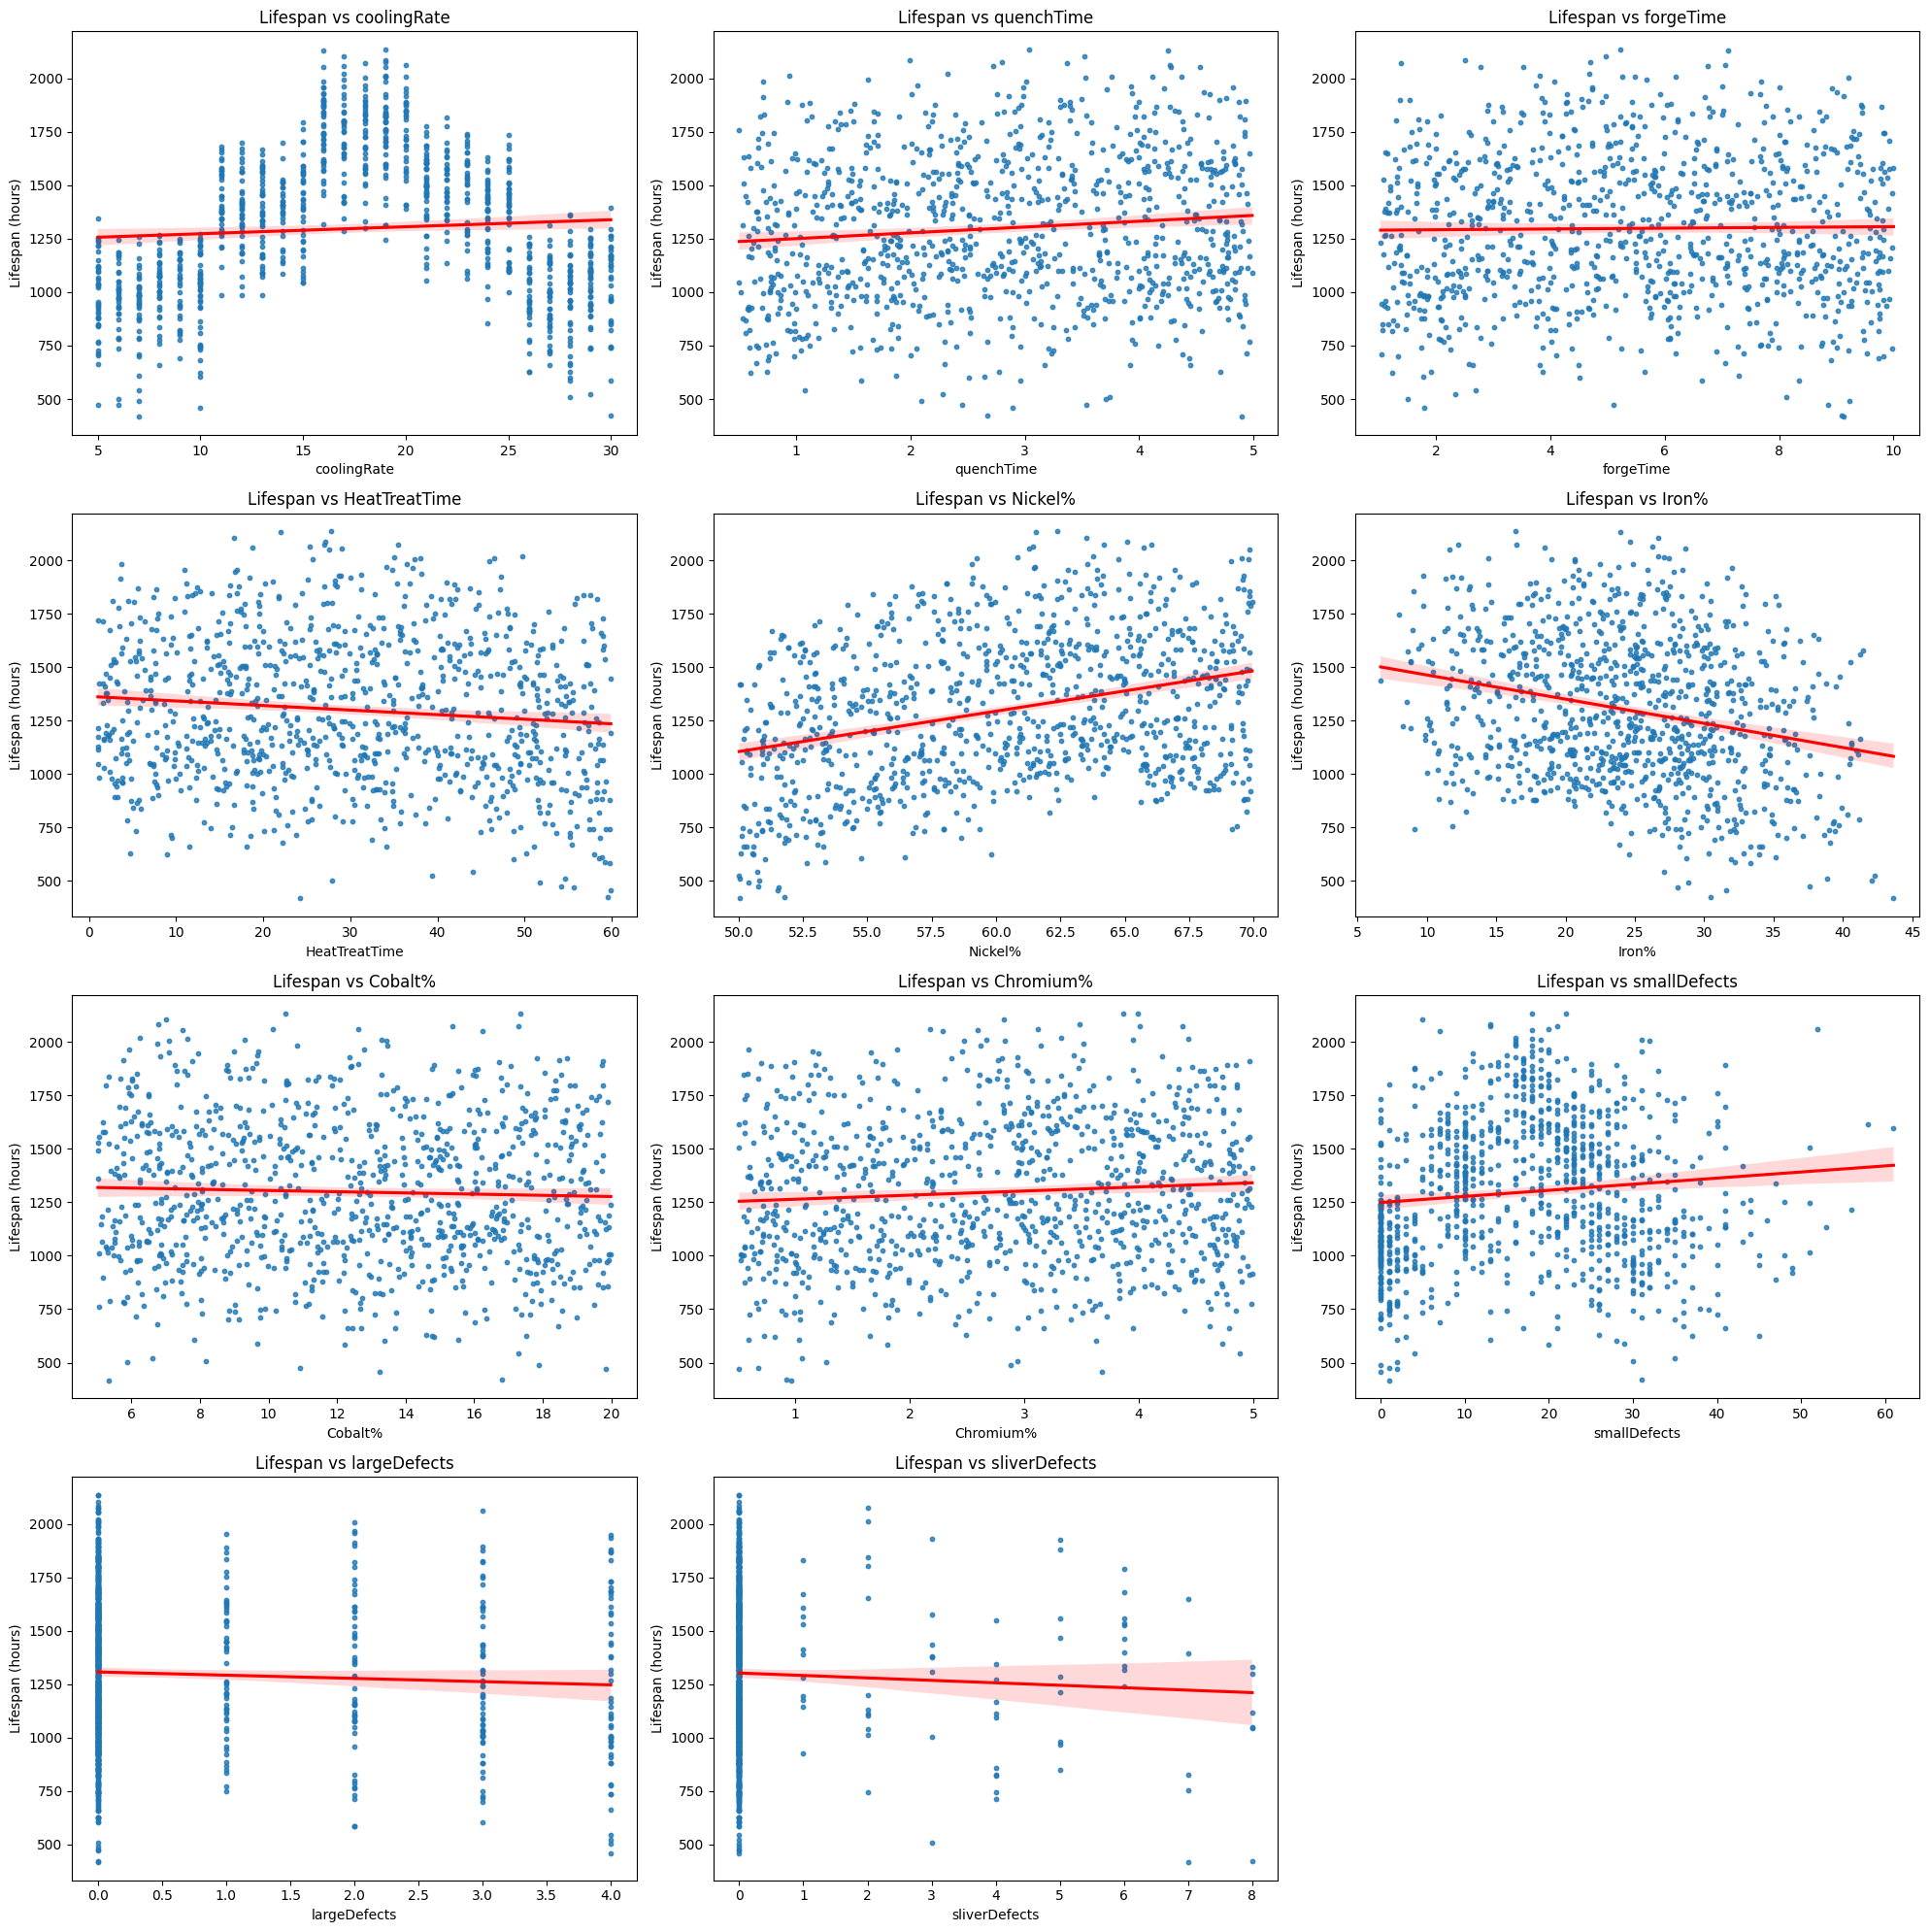

In [51]:
# Determine the number of rows and columns for the subplots
num_cols = len(numerical_cols)
nrows = num_cols // 3 + (num_cols % 3 > 0)  # Set up for 3 columns per row

# Create the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(20, nrows * 5))
axes = axes.flatten()  # Flatten to easily iterate over

# Plot each scatterplot with a regression trend line in a different subplot
for i, col in enumerate(numerical_cols):
    sns.regplot(ax=axes[i], data=df, x=col, y='Lifespan', scatter_kws={'s': 10}, line_kws={'color': 'red'})
    axes[i].set_title(f'Lifespan vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')

# Remove any empty subplots if the number of features is not perfectly divisible by 3
for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

#### Analysis of Scatter Plots: Relationships Between Features and Lifespan

From the scatter plots, we observed a variety of relationships between the numerical features and the lifespan of the metal parts. The cooling rate demonstrated a nearly horizontal trend line, indicating a weak positive correlation, meaning that while cooling may have a slight impact on the lifespan of the parts, it may not be a very strong predictor on its own. In contrast, quench time and forge time both showed a subtle upward trend, suggesting that increasing these times can slightly improve the durability of the metal parts. This indicates that certain controlled processing conditions, such as extended forging or quenching, might contribute positively to overall part longevity.

The effects of the alloy composition were more nuanced. A weak positive relationship was visible for `Nickel%` and `Chromium%`, implying that increased amounts of these elements could marginally enhance part lifespan, likely due to their known properties of increasing material strength and resistance. However, `Iron%` showed a slight negative correlation with lifespan, indicating that an increased percentage of iron might be detrimental to the durability of these parts, potentially contributing to brittleness. The effect of `Cobalt%` on lifespan appeared to be negligible, with only a very weak positive trend observed.

Interestingly, the defect features displayed mixed results. `SmallDefects` exhibited a weak positive trend with lifespan, suggesting that small defects might not significantly compromise the parts’ durability, or that other factors compensate for their presence. On the other hand, `LargeDefects` did not show any discernible trend, which was unexpected, as one might assume that larger defects would have a notable impact on part quality. This may imply that other factors play a mitigating role when large defects occur, or that their incidence is not high enough in the dataset to produce a clear trend. Lastly, `SliverDefects` showed a weak negative trend, which aligns with expectations, as these defects could create structural weaknesses, albeit with only a minor impact.

Overall, the analysis suggests that while some features—such as `forgeTime`, `quenchTime`, and `Nickel%`—have a slight positive influence on lifespan, most relationships are relatively weak, implying that more complex interactions or non-linear relationships may be at play. This points to the need for deeper analysis through interaction terms, feature transformations, or non-linear modeling techniques to fully capture the intricacies of how processing conditions and material composition affect the lifespan of the parts.

---

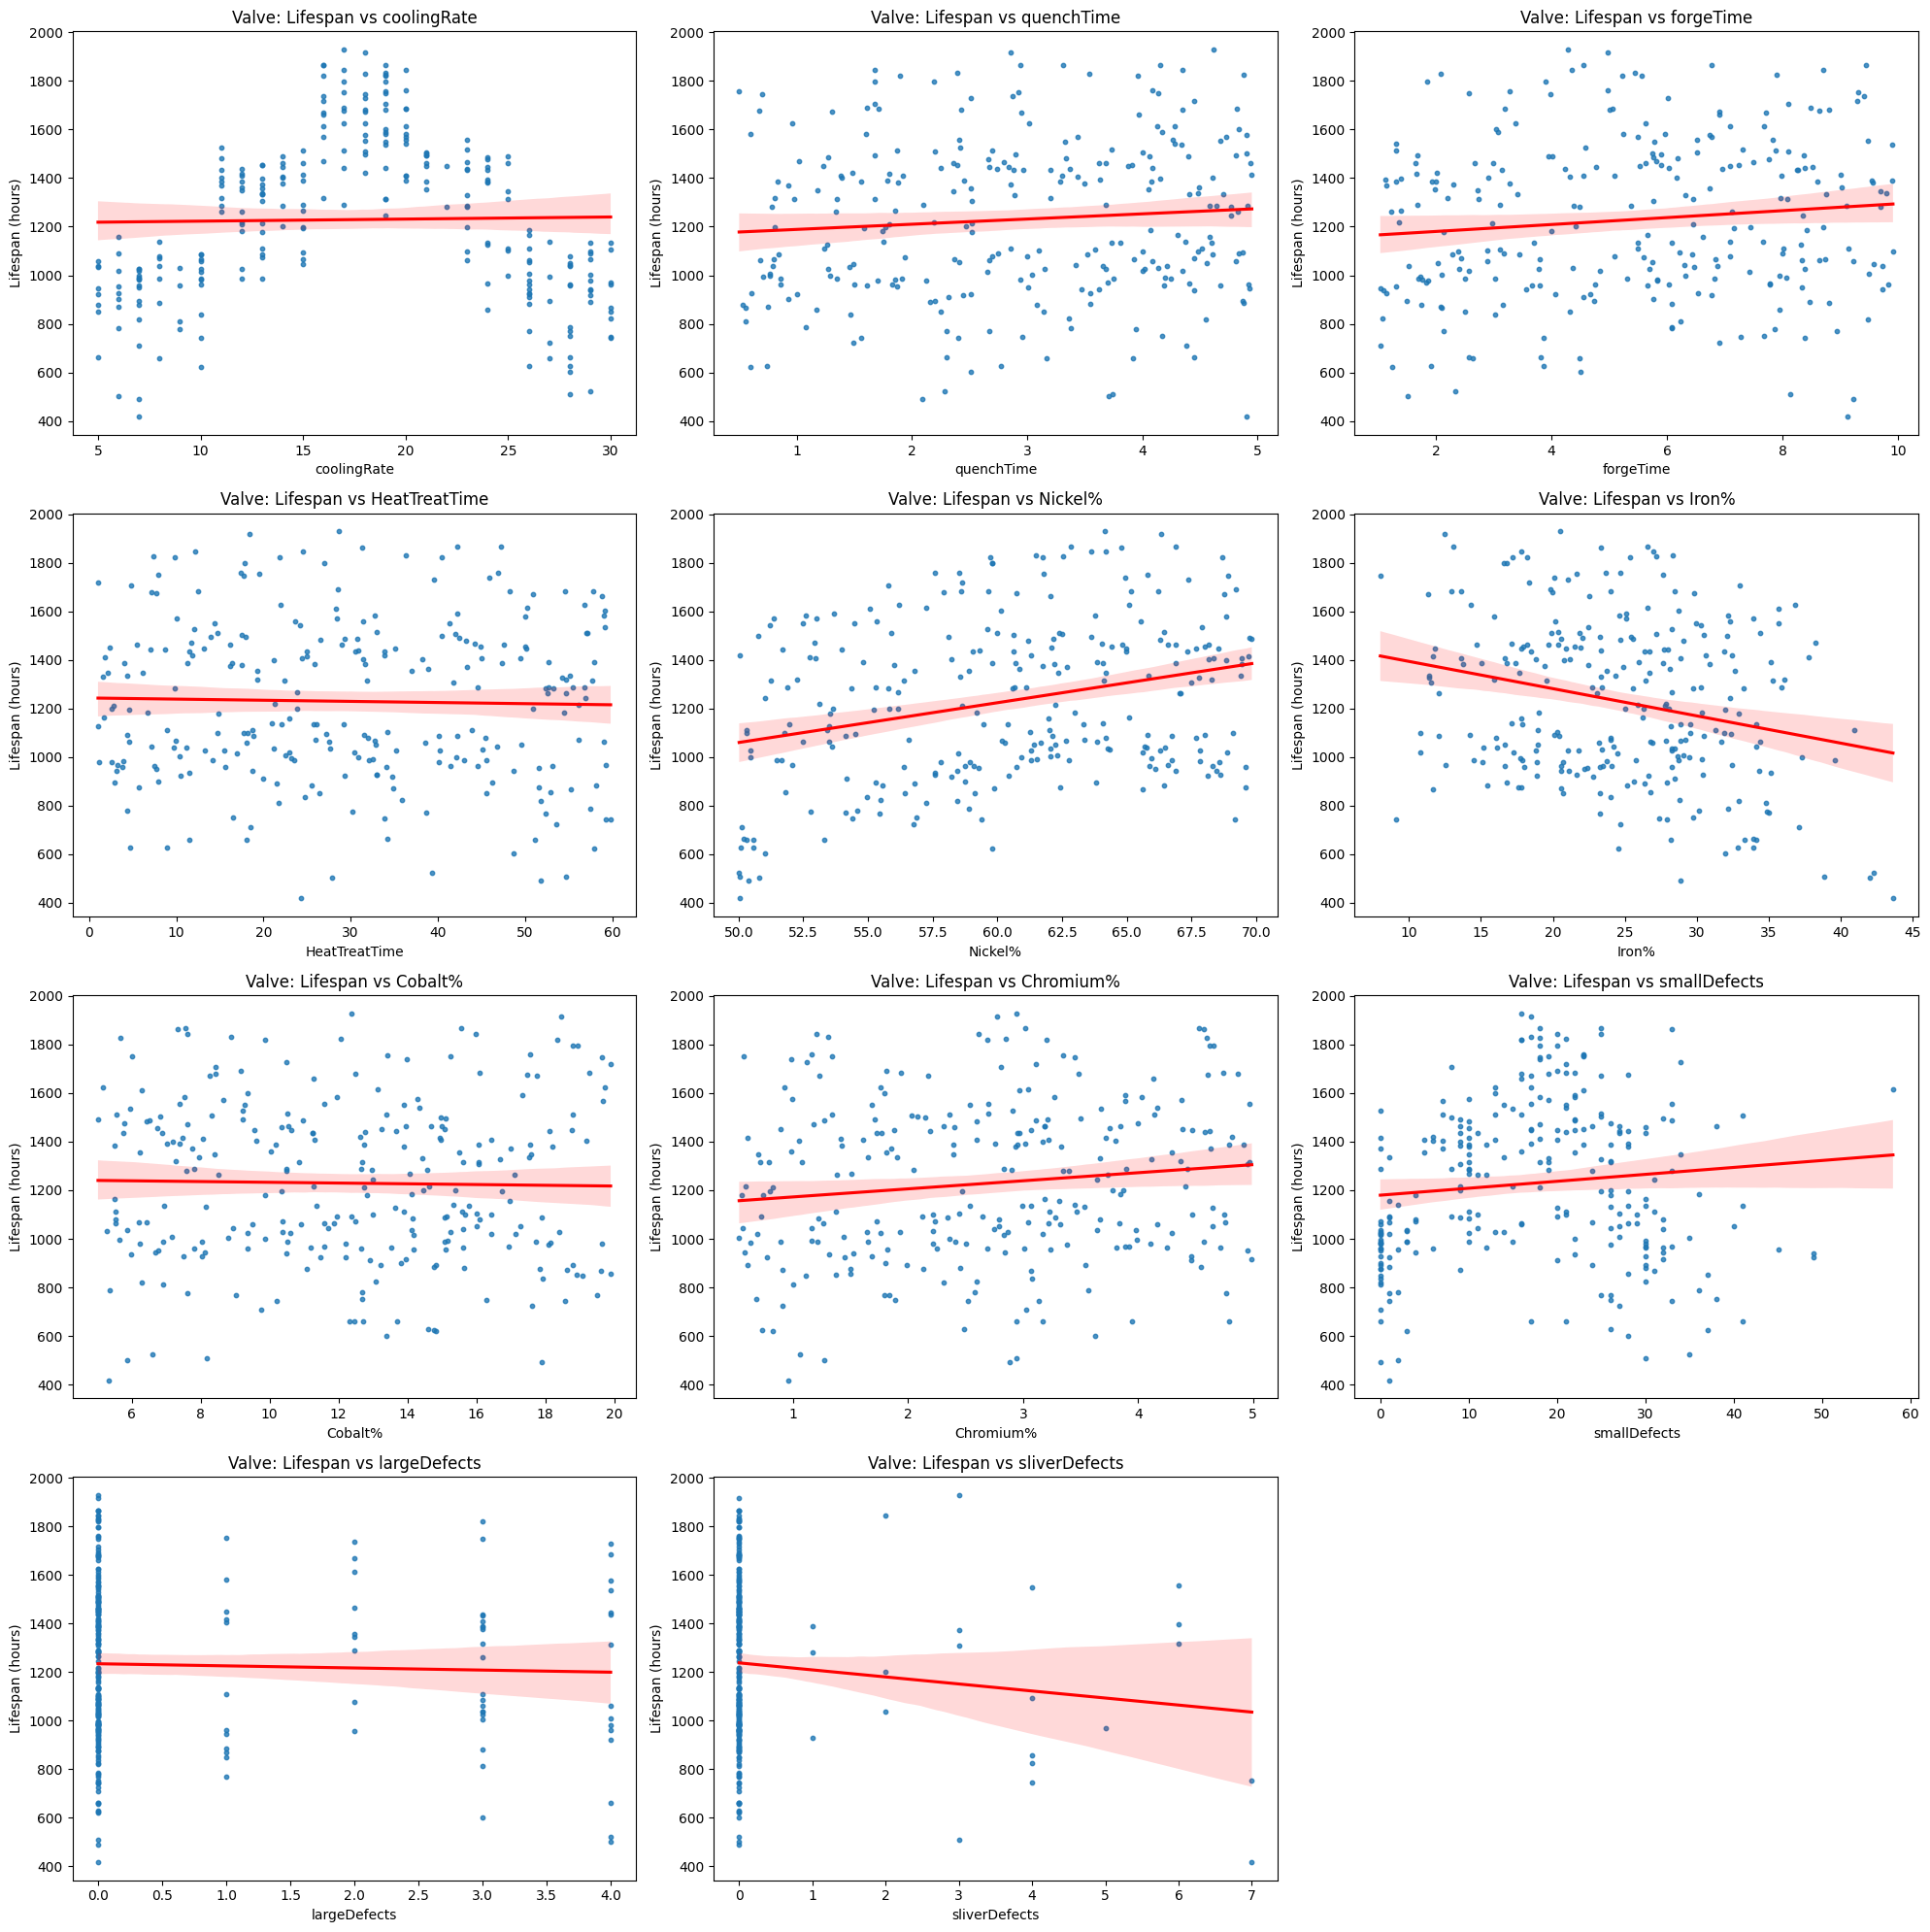

In [53]:
# 1. Scatter Plots for Valve
valve_data = df[df['partType'] == 'Valve']
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
axes = axes.flatten()
for i, col in enumerate(numerical_cols):
    sns.regplot(ax=axes[i], data=valve_data, x=col, y='Lifespan', scatter_kws={'s': 10}, line_kws={'color': 'red'})
    axes[i].set_title(f'Valve: Lifespan vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')
for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

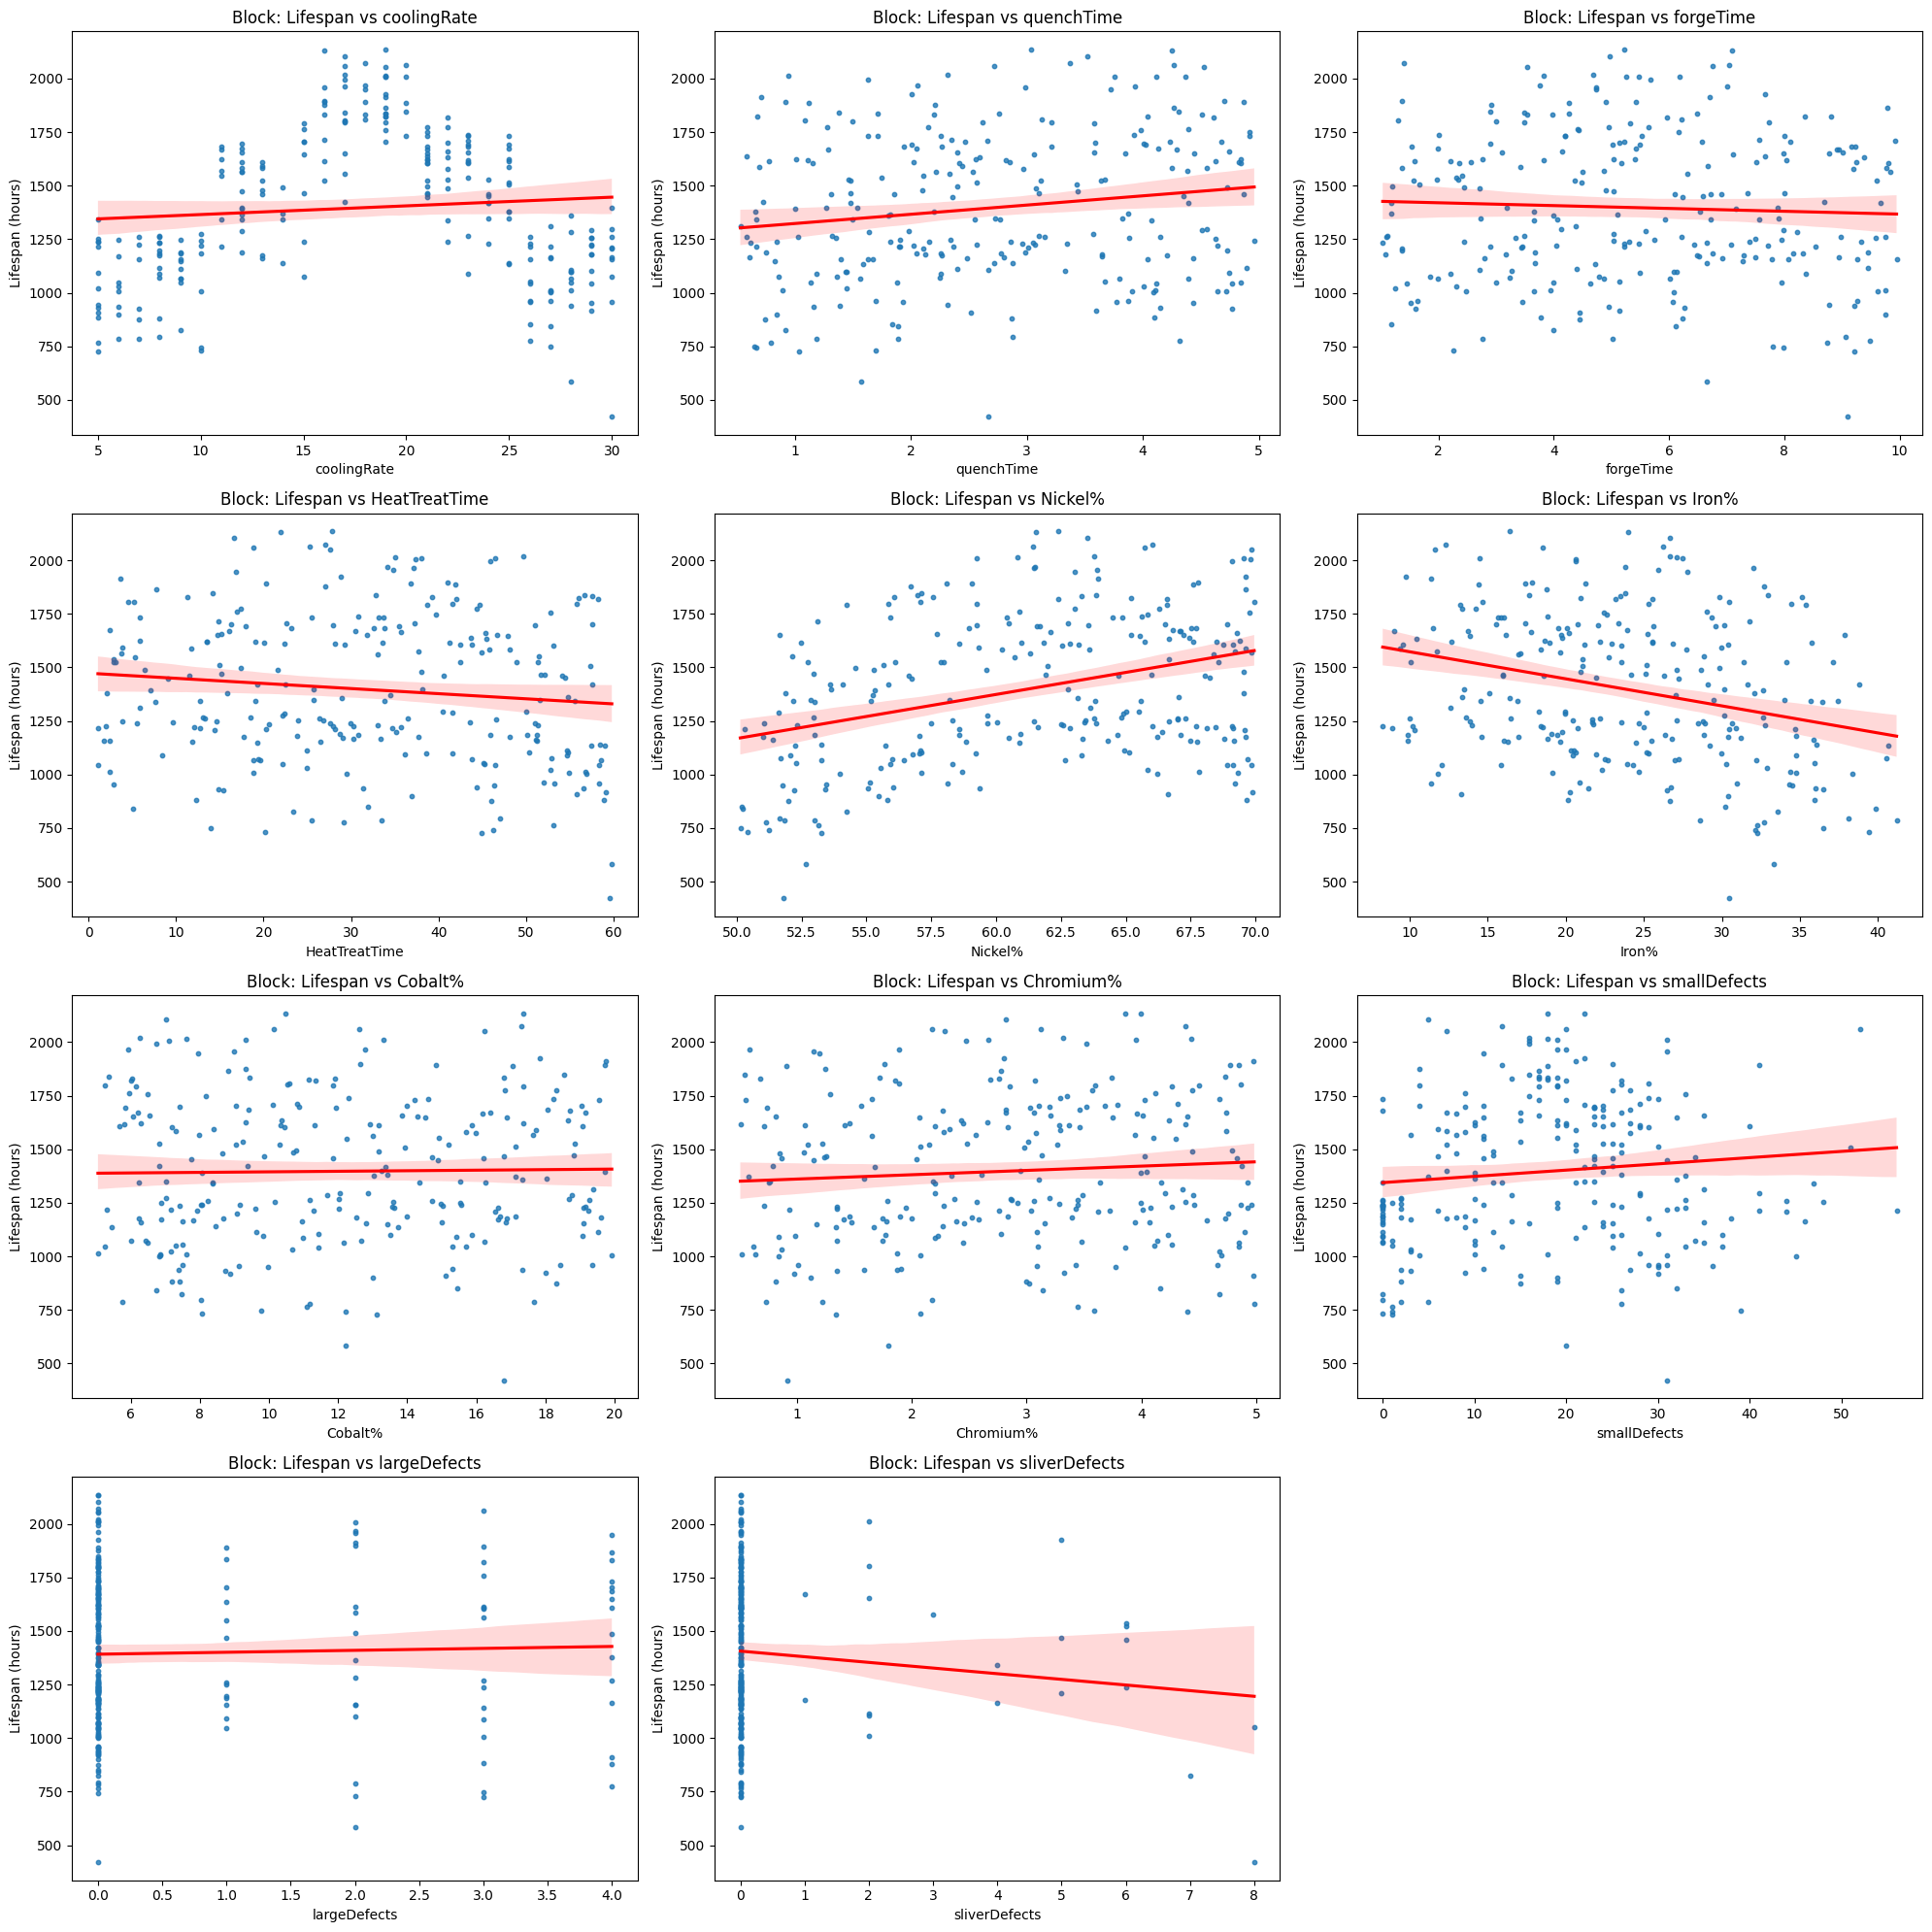

In [54]:
# 2. Scatter Plots for Block
block_data = df[df['partType'] == 'Block']
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
axes = axes.flatten()
for i, col in enumerate(numerical_cols):
    sns.regplot(ax=axes[i], data=block_data, x=col, y='Lifespan', scatter_kws={'s': 10}, line_kws={'color': 'red'})
    axes[i].set_title(f'Block: Lifespan vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')
for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

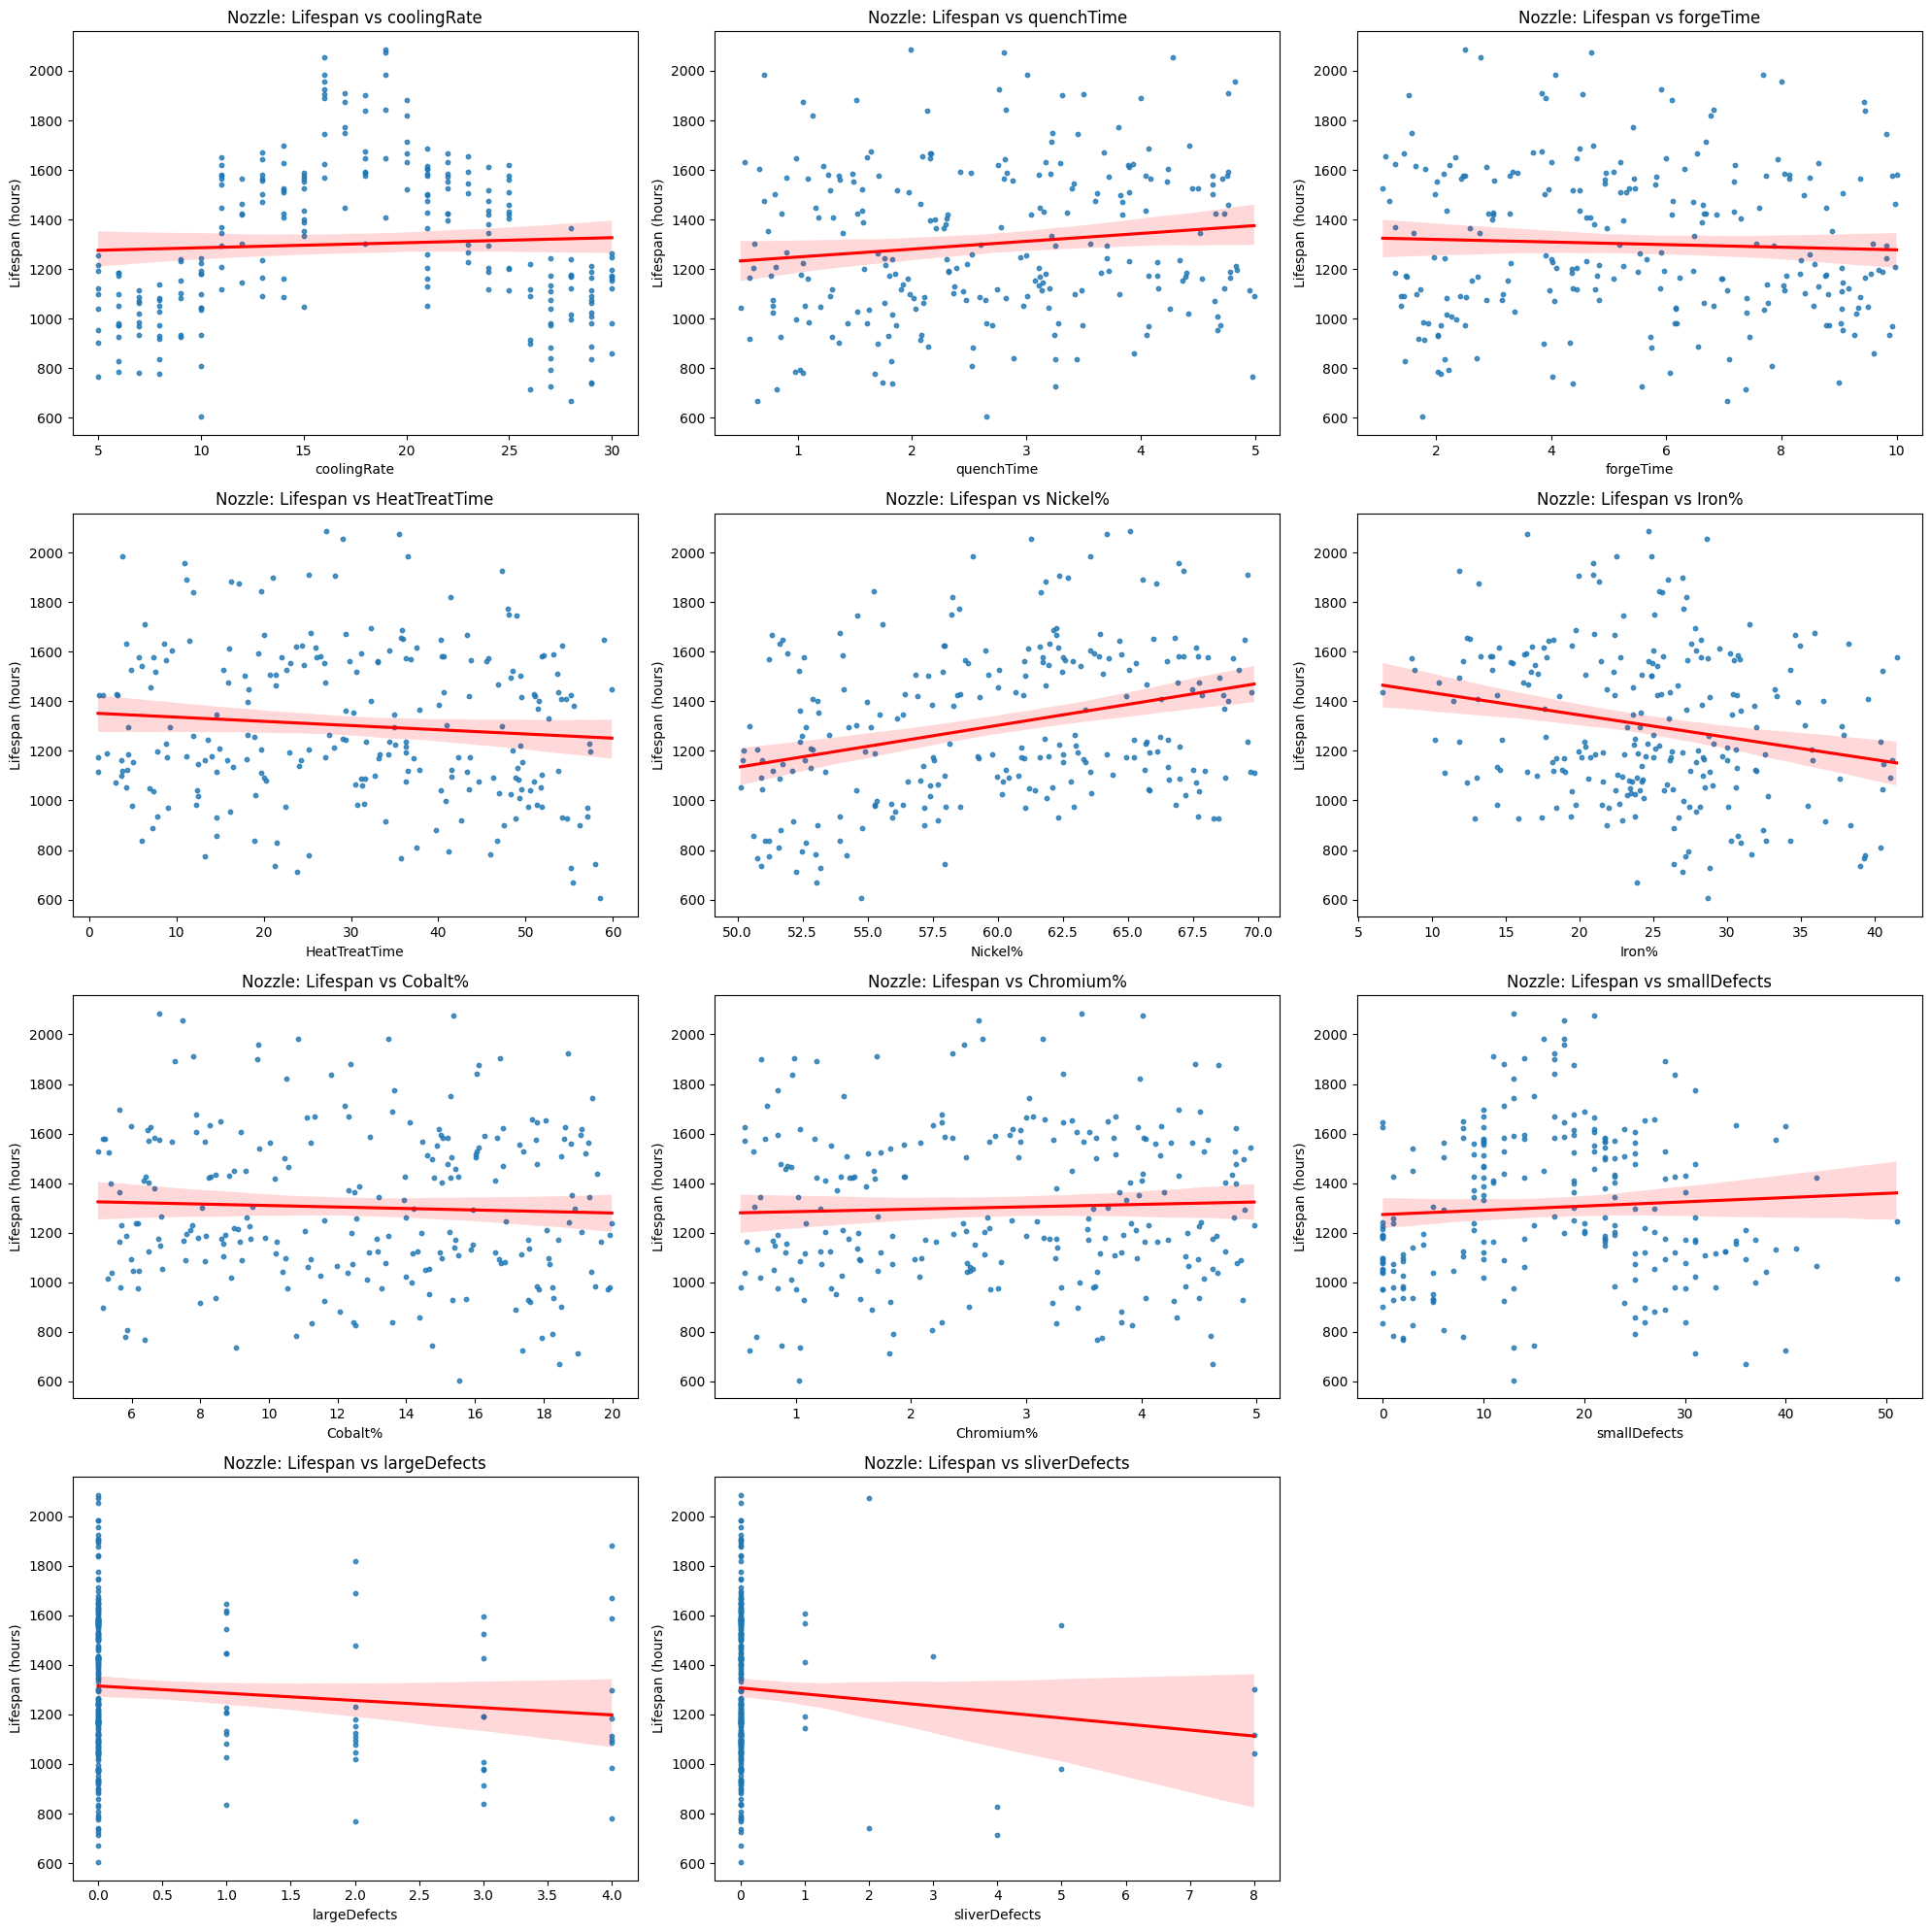

In [55]:
# 3. Scatter Plots for Nozzle
nozzle_data = df[df['partType'] == 'Nozzle']
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
axes = axes.flatten()
for i, col in enumerate(numerical_cols):
    sns.regplot(ax=axes[i], data=nozzle_data, x=col, y='Lifespan', scatter_kws={'s': 10}, line_kws={'color': 'red'})
    axes[i].set_title(f'Nozzle: Lifespan vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')
for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

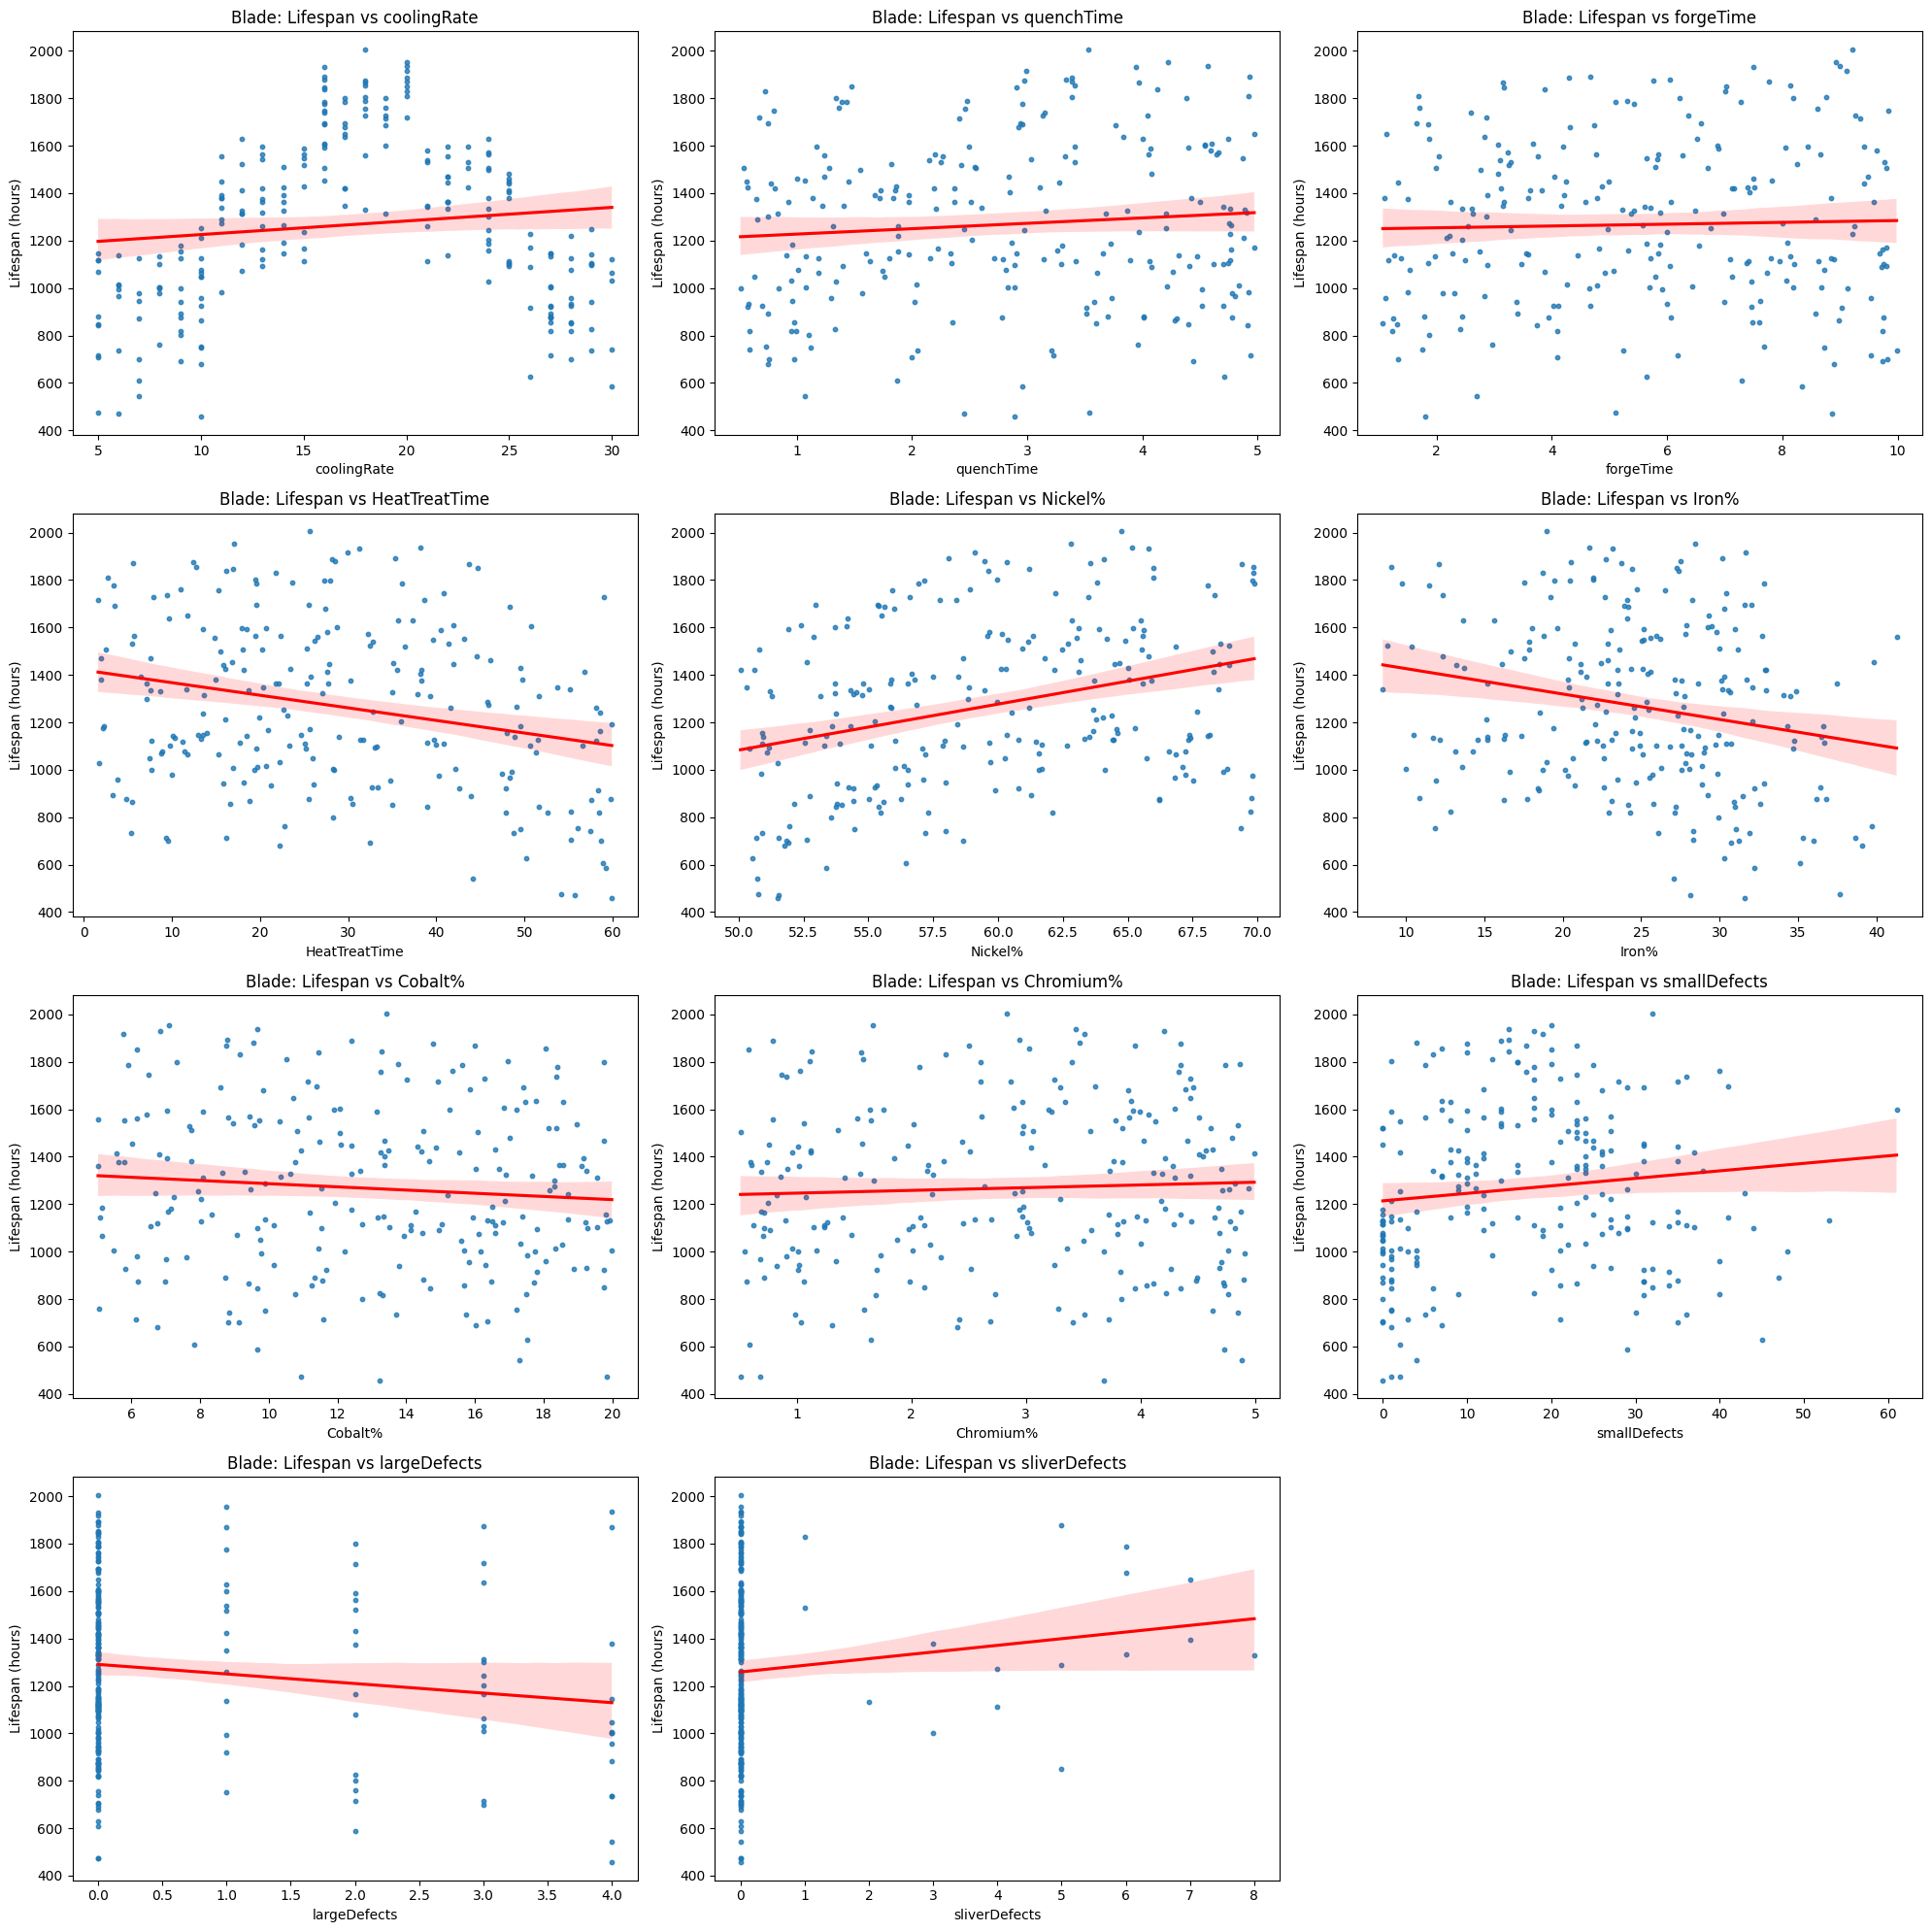

In [56]:
# 4. Scatter Plots for Blade
blade_data = df[df['partType'] == 'Blade']
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
axes = axes.flatten()
for i, col in enumerate(numerical_cols):
    sns.regplot(ax=axes[i], data=blade_data, x=col, y='Lifespan', scatter_kws={'s': 10}, line_kws={'color': 'red'})
    axes[i].set_title(f'Blade: Lifespan vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')
for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

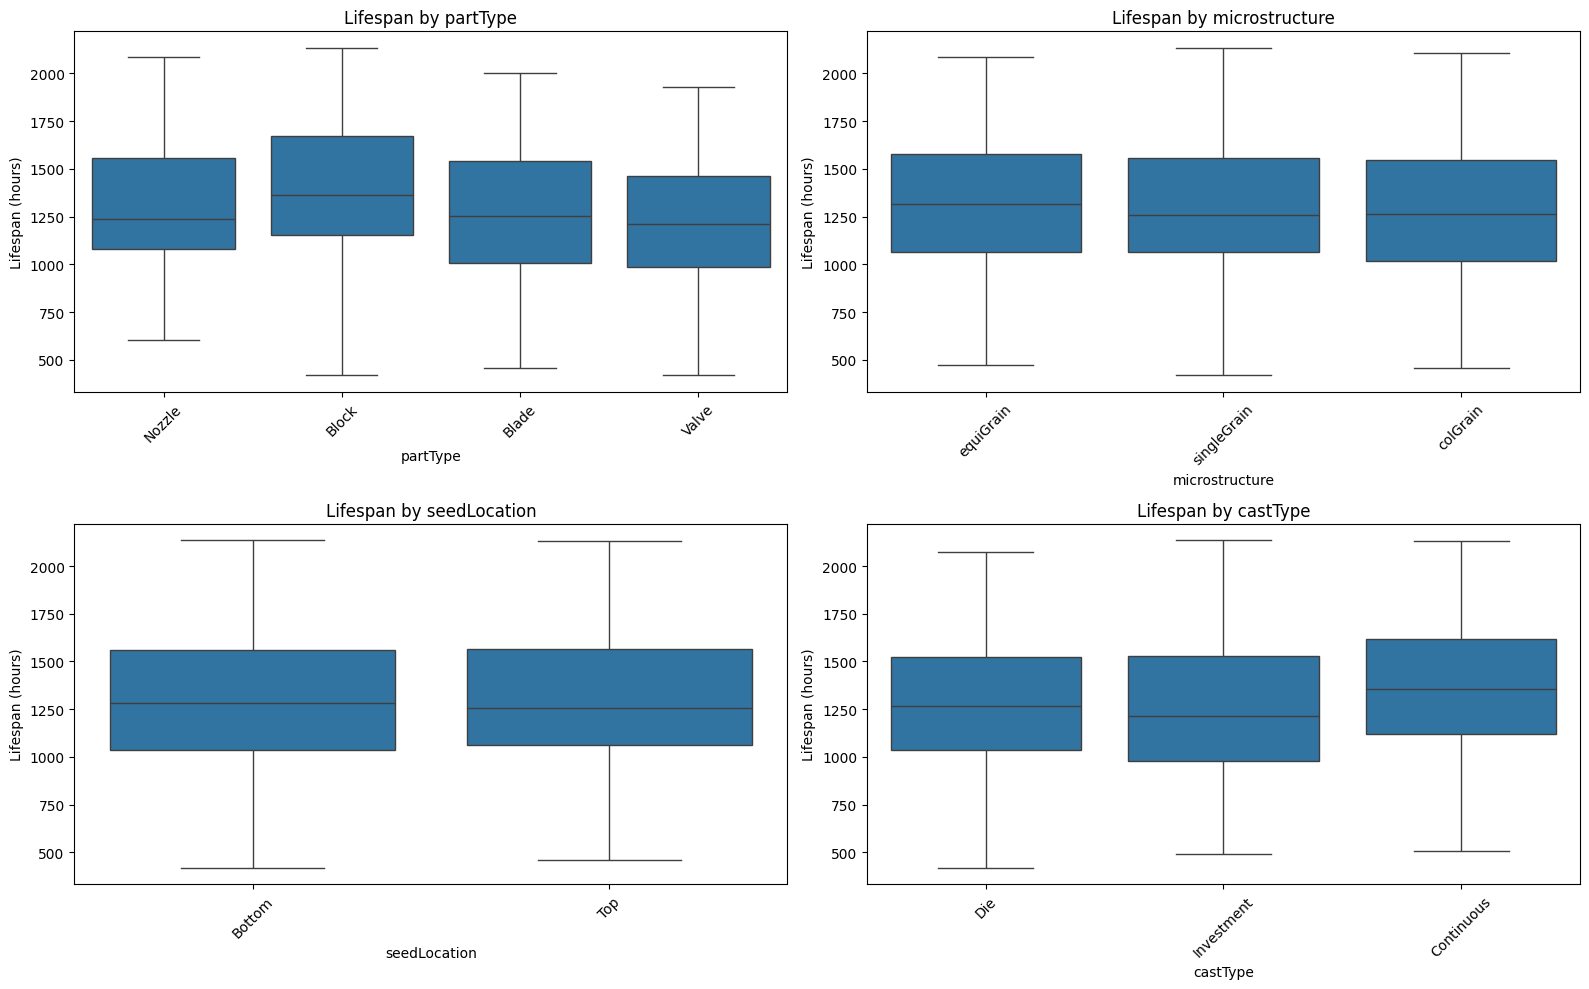

In [34]:
# List of categorical columns to include in the box plots
categorical_cols = ['partType', 'microstructure', 'seedLocation', 'castType']

# Determine the number of rows and columns for the subplots
num_cols = len(categorical_cols)
nrows = num_cols // 2 + (num_cols % 2 > 0)  # Set up for 2 columns per row for better readability

# Create the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(16, nrows * 5))
axes = axes.flatten()  # Flatten the axes array to easily iterate over

# Plot each boxplot in a different subplot
for i, col in enumerate(categorical_cols):
    sns.boxplot(ax=axes[i], x=col, y='Lifespan', data=df)
    axes[i].set_title(f'Lifespan by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')
    axes[i].tick_params(axis='x', rotation=45)

# Remove any empty subplots if the number of features is odd
for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

# Detailed explanation:
# Observations for Lifespan by Categorical Features:
# - Compare the median lifespan across different categories within each feature.
#   For example, evaluate which 'microstructure' type has the longest or shortest median lifespan.
# - The interquartile range (box size) indicates the variability within each category.
#   A larger IQR indicates inconsistency, which might signal that certain processes yield inconsistent quality.
# - Outliers (dots outside whiskers) may indicate unusual parts with significantly different lifespans.
#   These might be useful for further investigation to improve quality control.
# - Observe if certain categories have notably lower median lifespans, which could indicate problematic production techniques.


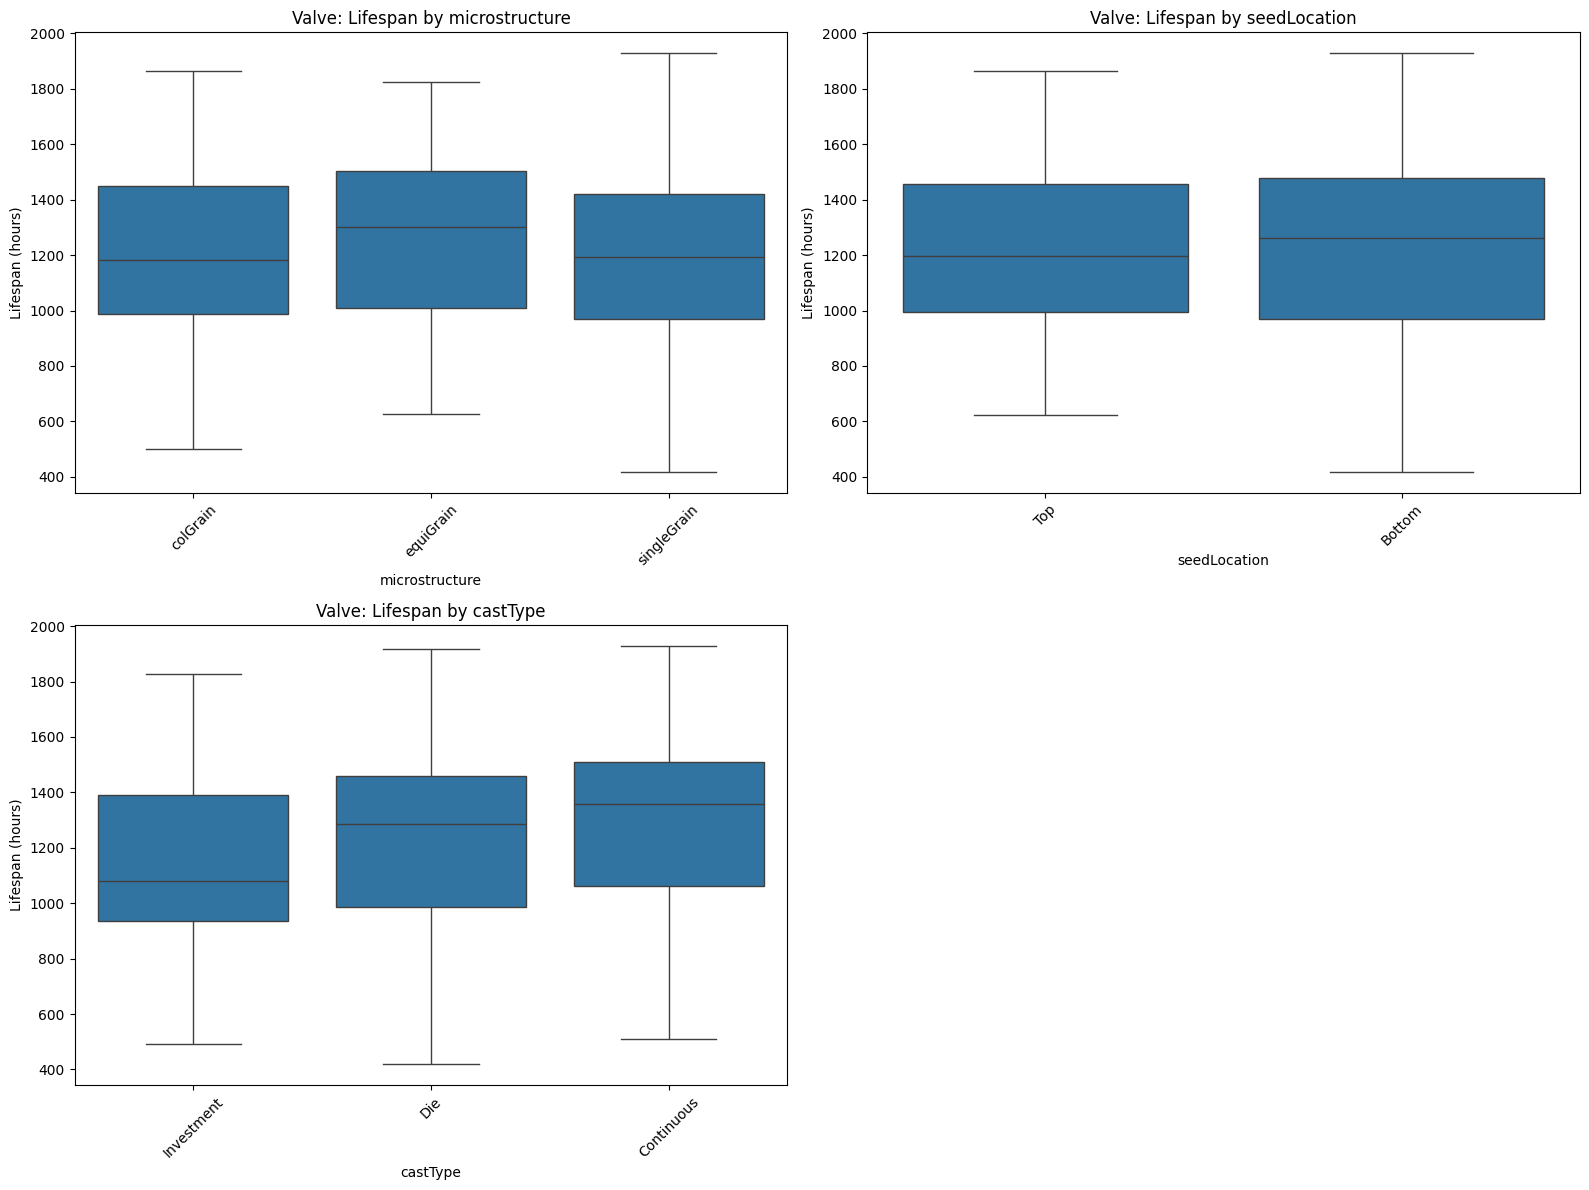

In [57]:
# 1. Box Plots for Valve
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()
for i, col in enumerate(['microstructure', 'seedLocation', 'castType']):
    sns.boxplot(ax=axes[i], x=col, y='Lifespan', data=valve_data)
    axes[i].set_title(f'Valve: Lifespan by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')
    axes[i].tick_params(axis='x', rotation=45)
for j in range(len(['microstructure', 'seedLocation', 'castType']), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

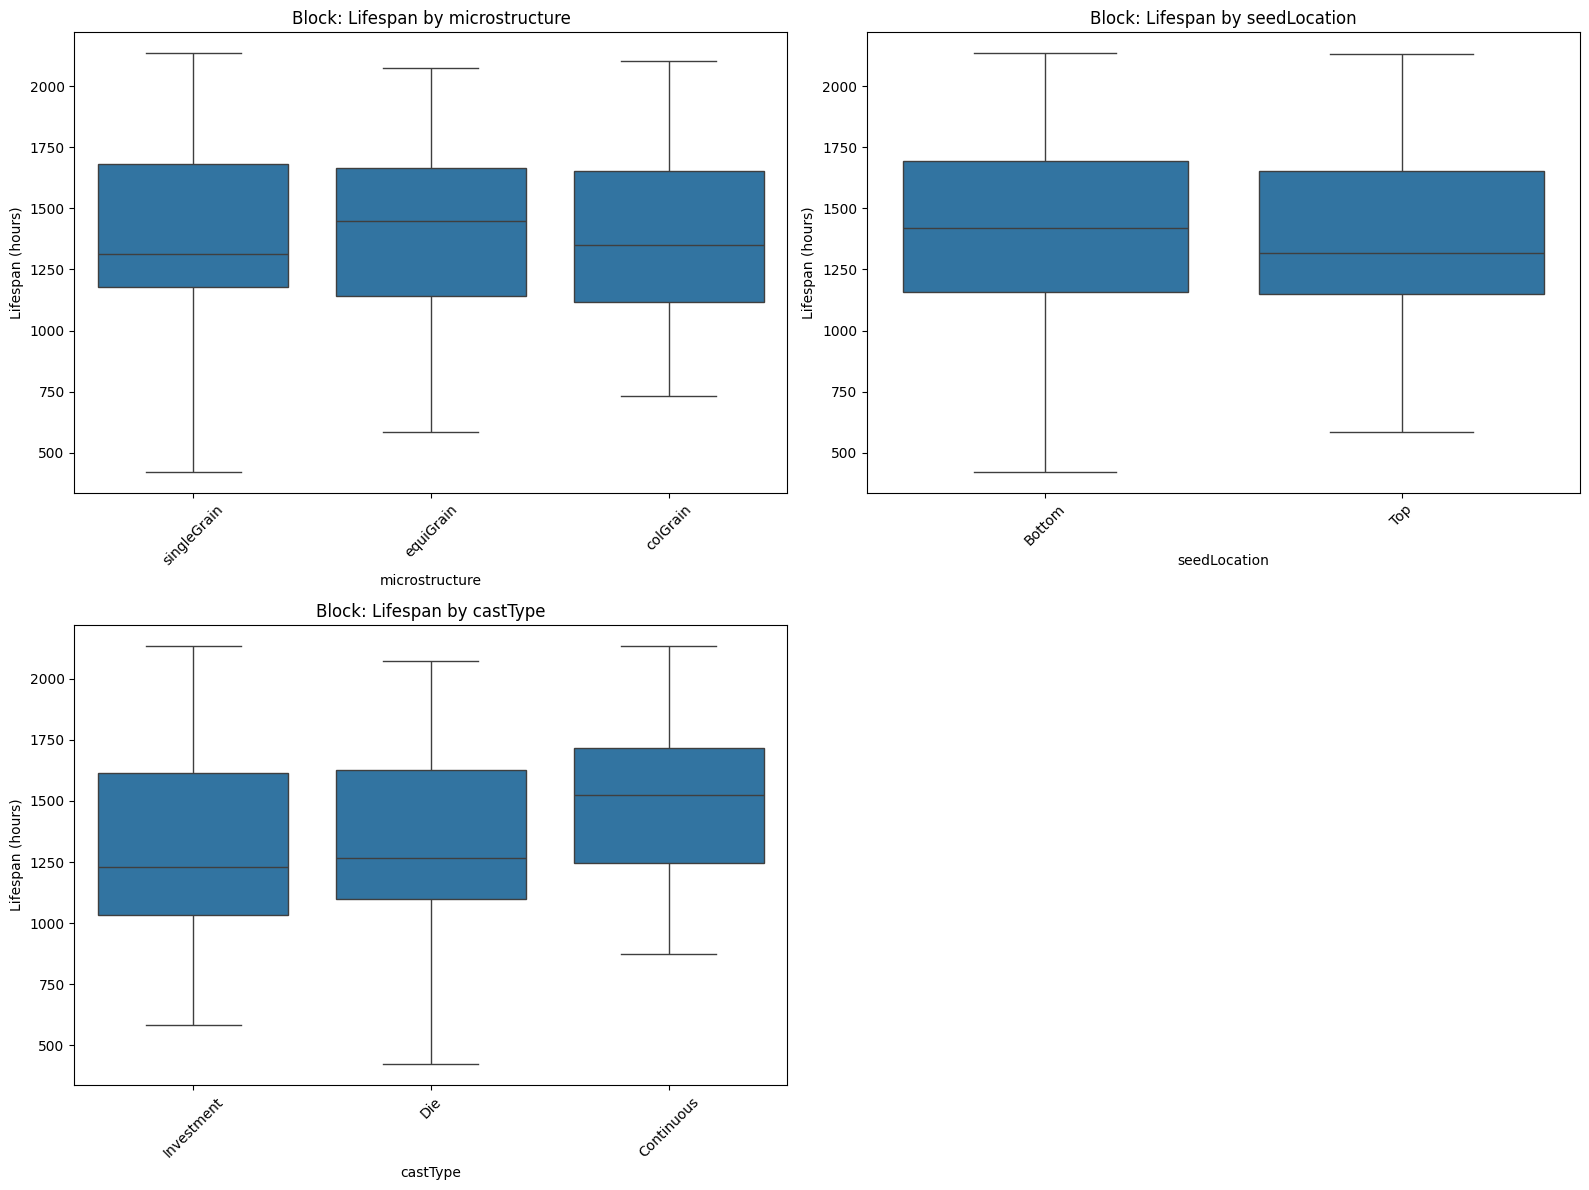

In [58]:
# 2. Box Plots for Block
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()
for i, col in enumerate(['microstructure', 'seedLocation', 'castType']):
    sns.boxplot(ax=axes[i], x=col, y='Lifespan', data=block_data)
    axes[i].set_title(f'Block: Lifespan by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')
    axes[i].tick_params(axis='x', rotation=45)
for j in range(len(['microstructure', 'seedLocation', 'castType']), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

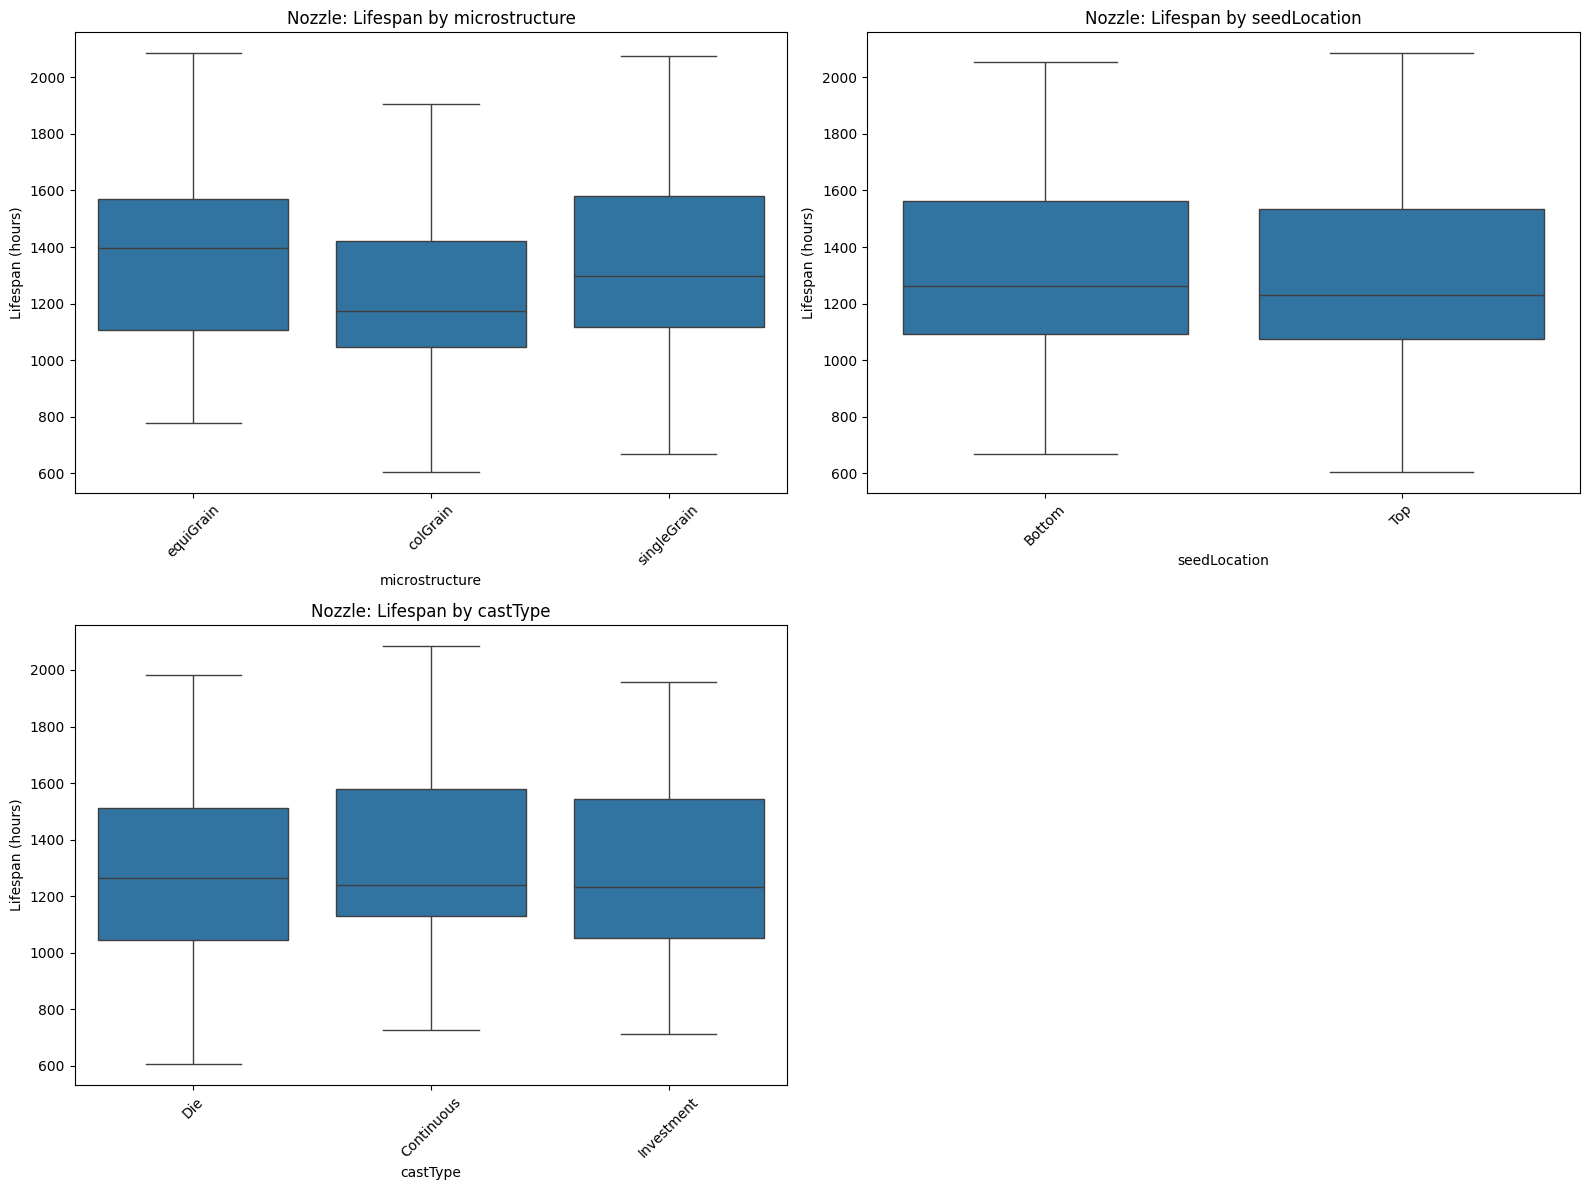

In [59]:
# 3. Box Plots for Nozzle
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()
for i, col in enumerate(['microstructure', 'seedLocation', 'castType']):
    sns.boxplot(ax=axes[i], x=col, y='Lifespan', data=nozzle_data)
    axes[i].set_title(f'Nozzle: Lifespan by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')
    axes[i].tick_params(axis='x', rotation=45)
for j in range(len(['microstructure', 'seedLocation', 'castType']), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

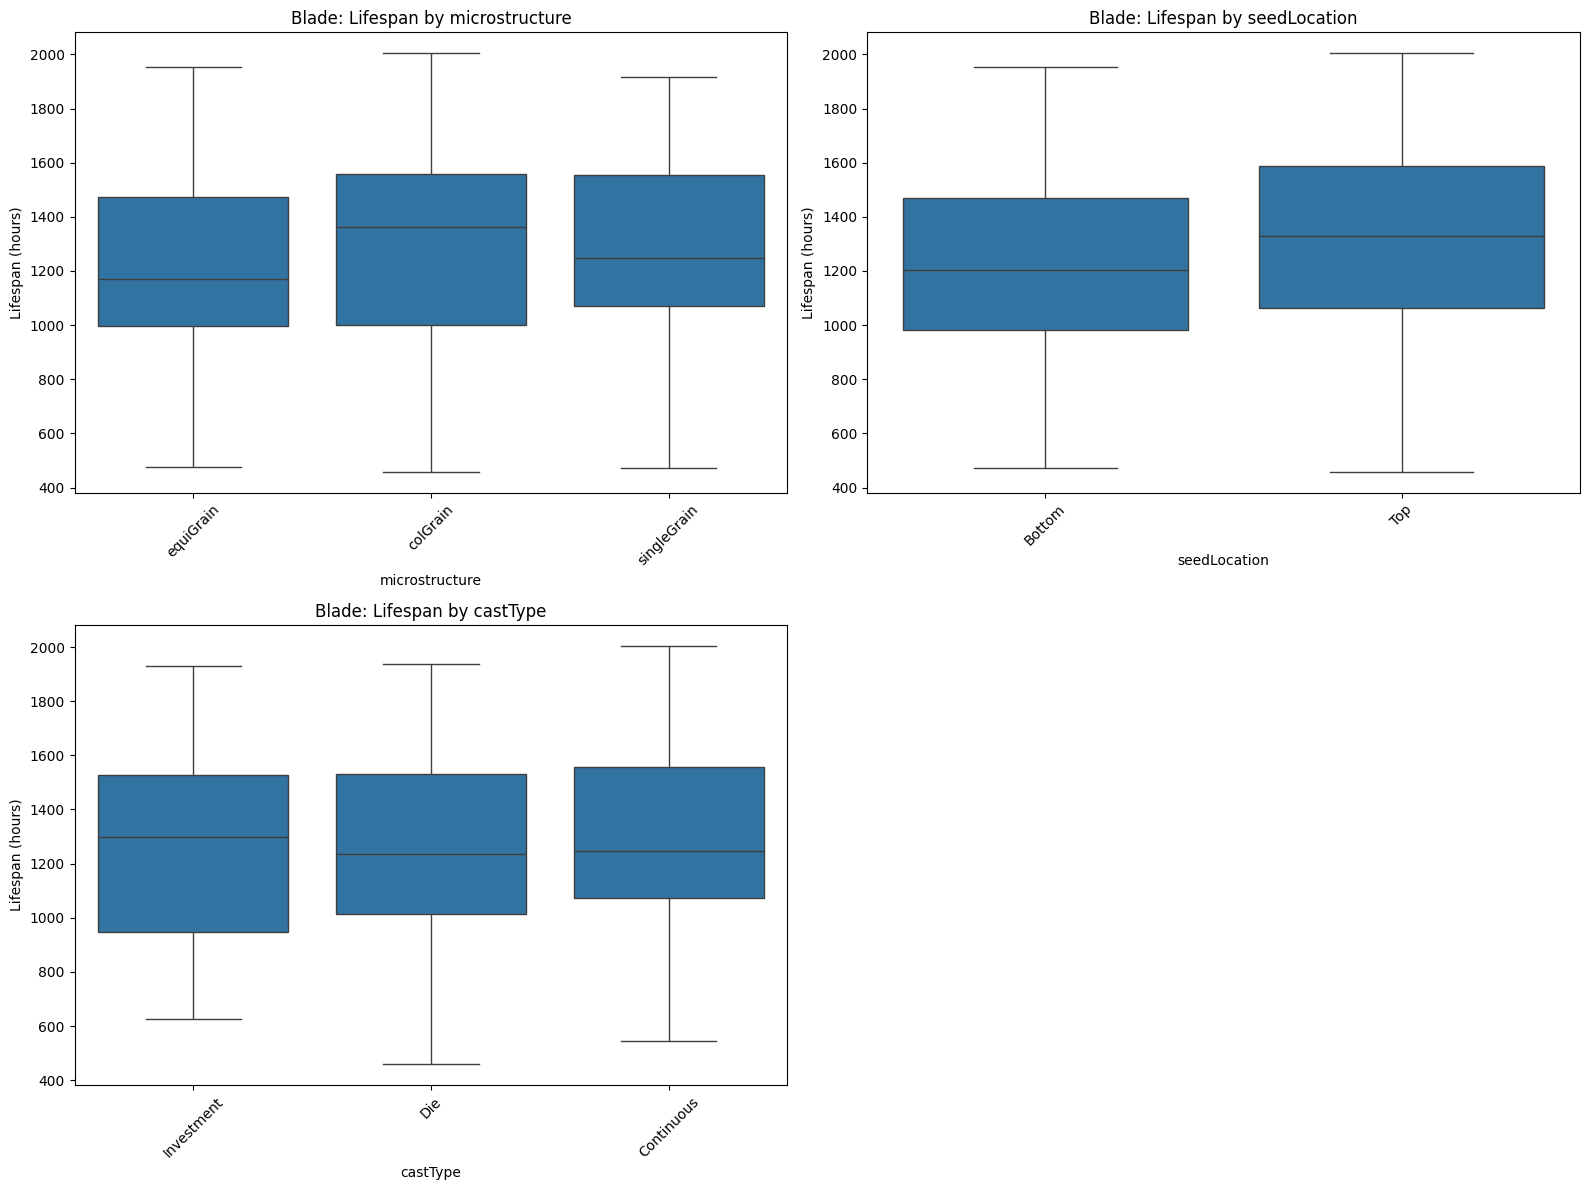

In [60]:
# 4. Box Plots for Blade
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()
for i, col in enumerate(['microstructure', 'seedLocation', 'castType']):
    sns.boxplot(ax=axes[i], x=col, y='Lifespan', data=blade_data)
    axes[i].set_title(f'Blade: Lifespan by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')
    axes[i].tick_params(axis='x', rotation=45)
for j in range(len(['microstructure', 'seedLocation', 'castType']), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

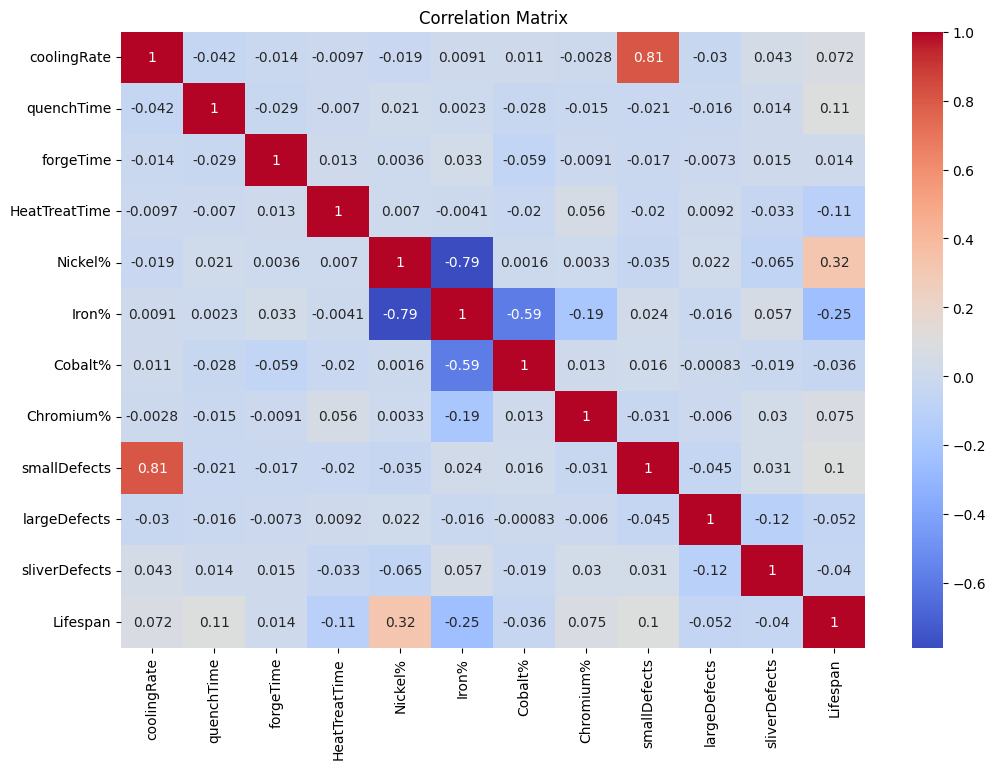

In [35]:
# Include 'Lifespan' in the correlation matrix
numerical_cols_with_target = numerical_cols + ['Lifespan']
corr_matrix = df[numerical_cols_with_target].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

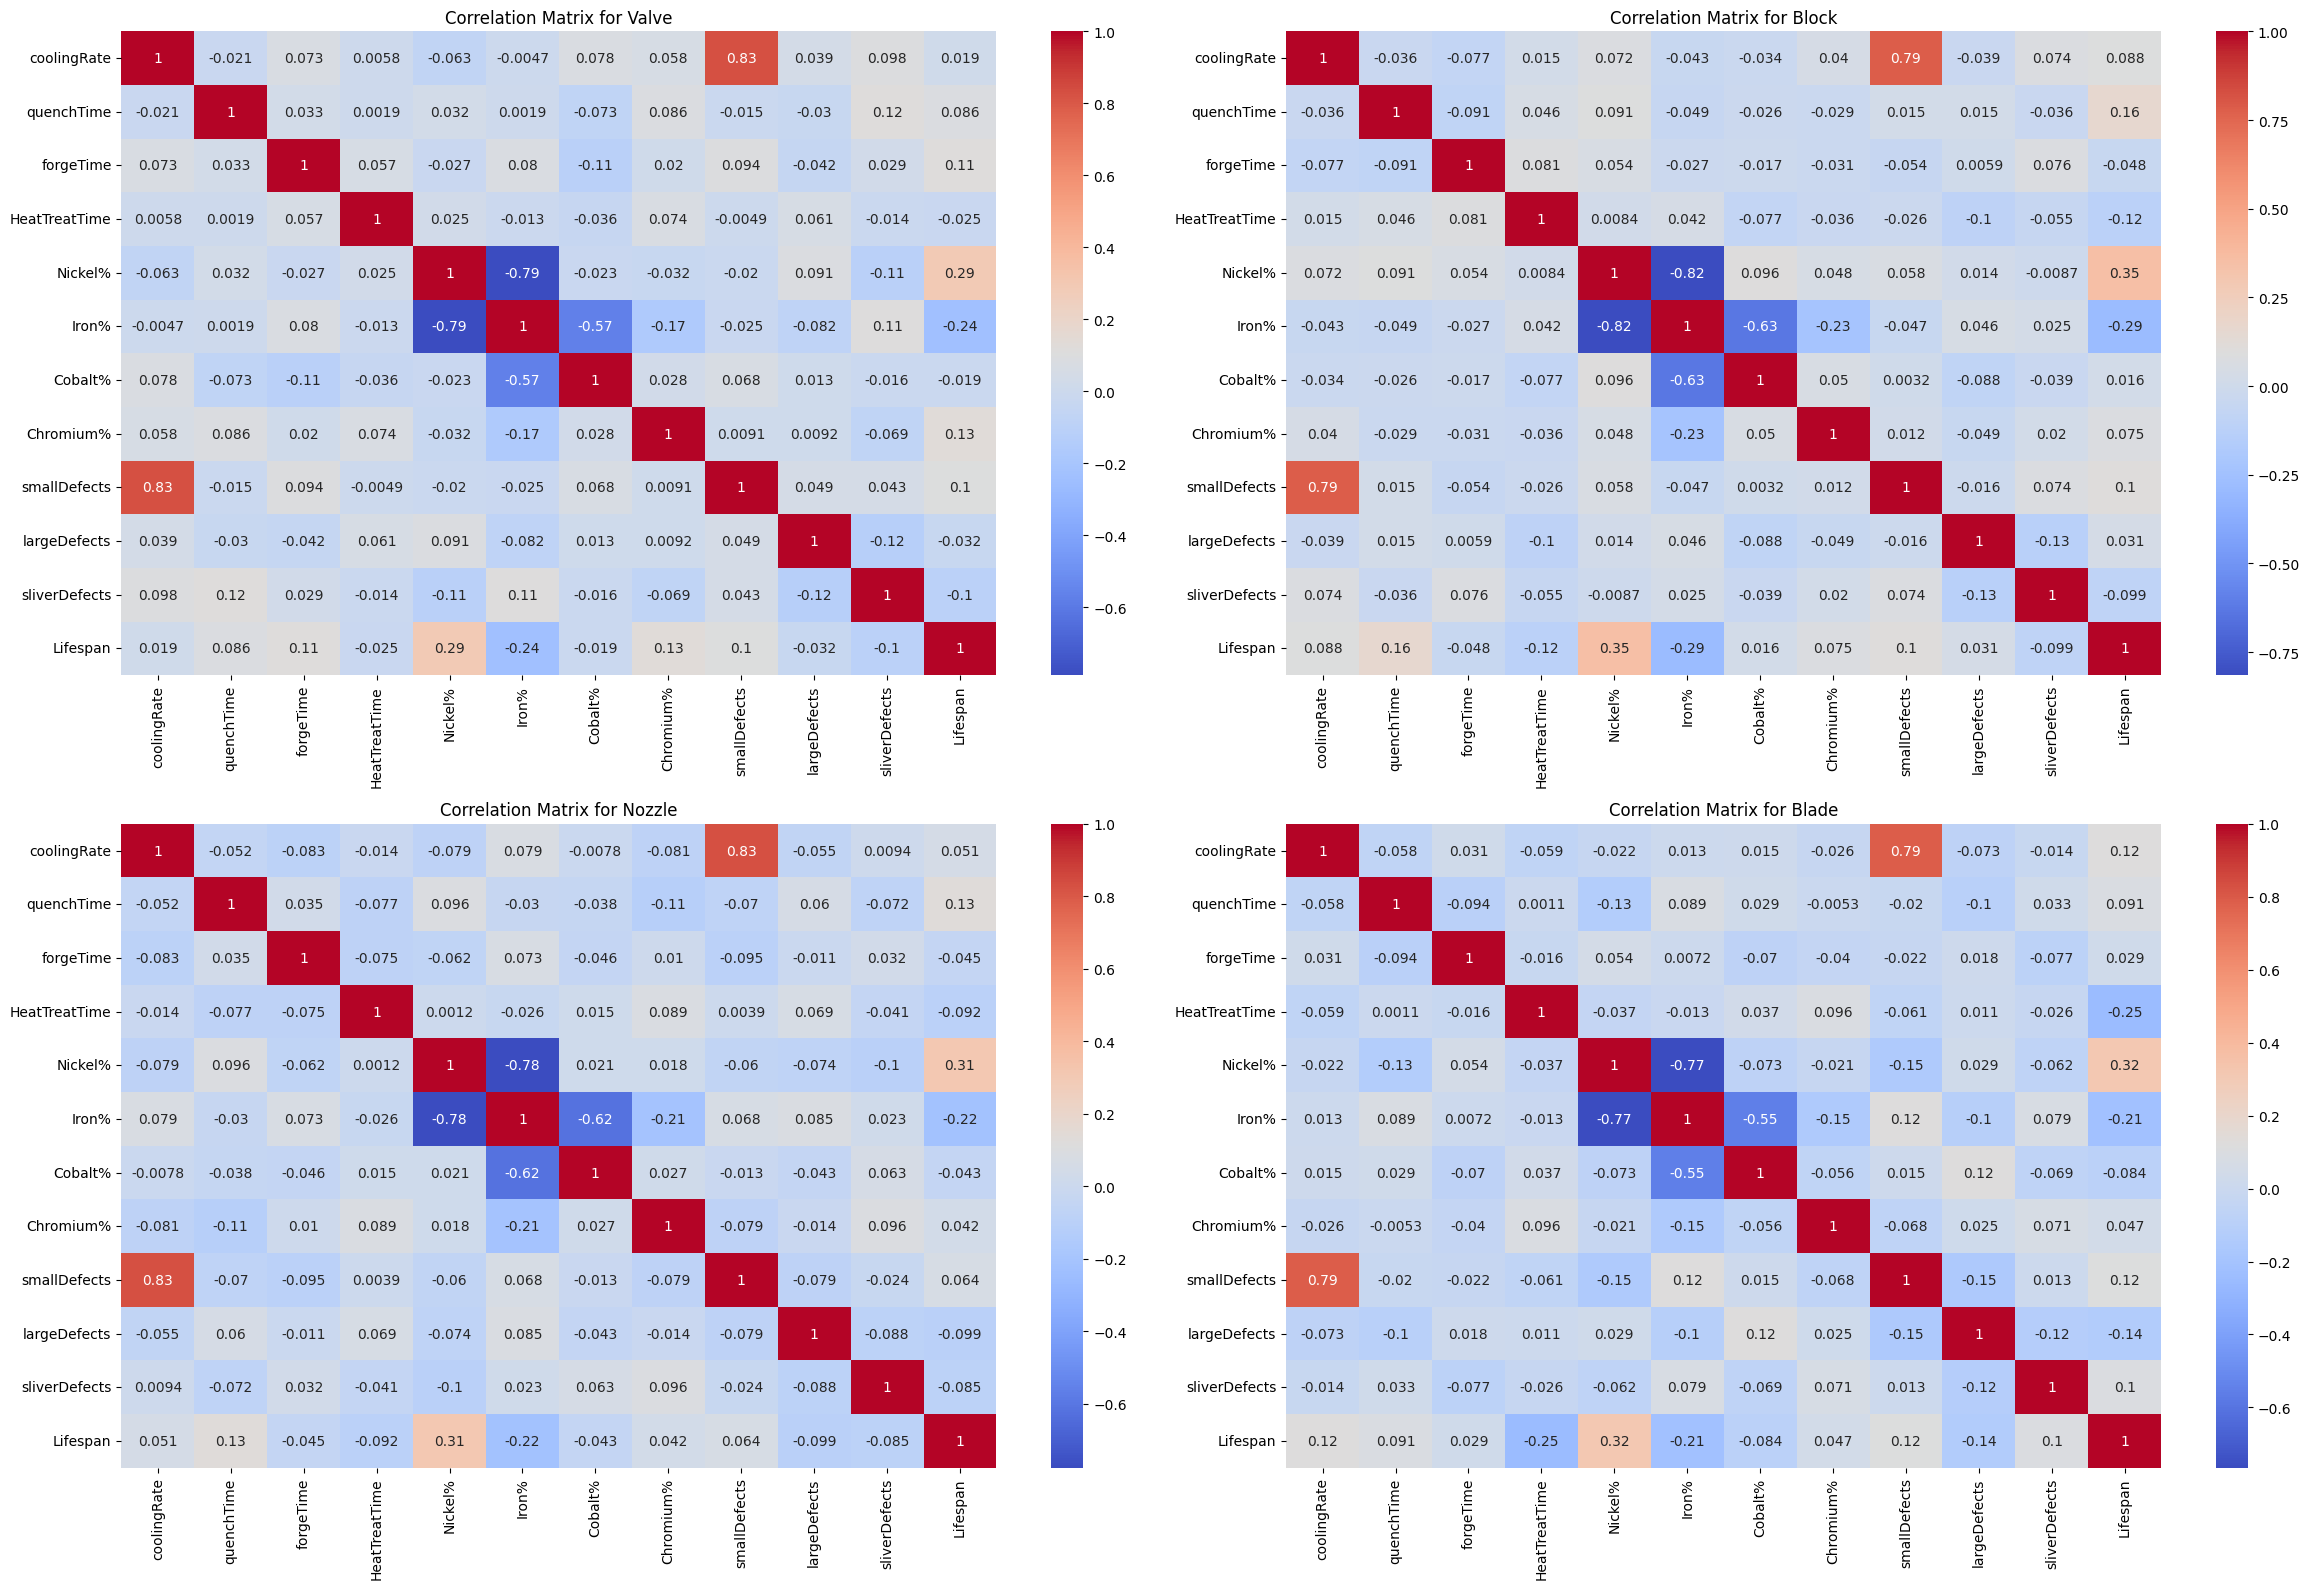

In [65]:
# Correlation Matrices for All Metal Parts in Subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 16))
axes = axes.flatten()

# 1. Correlation Matrix for Valve
valve_corr_matrix = valve_data[numerical_cols + ['Lifespan']].corr()
sns.heatmap(valve_corr_matrix, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Correlation Matrix for Valve')

# 2. Correlation Matrix for Block
block_corr_matrix = block_data[numerical_cols + ['Lifespan']].corr()
sns.heatmap(block_corr_matrix, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Correlation Matrix for Block')

# 3. Correlation Matrix for Nozzle
nozzle_corr_matrix = nozzle_data[numerical_cols + ['Lifespan']].corr()
sns.heatmap(nozzle_corr_matrix, annot=True, cmap='coolwarm', ax=axes[2])
axes[2].set_title('Correlation Matrix for Nozzle')

# 4. Correlation Matrix for Blade
blade_corr_matrix = blade_data[numerical_cols + ['Lifespan']].corr()
sns.heatmap(blade_corr_matrix, annot=True, cmap='coolwarm', ax=axes[3])
axes[3].set_title('Correlation Matrix for Blade')

plt.tight_layout()
plt.show()

### Feature Engineering

Polynomial Features: For `CoolingRate`, create a squared term to capture non-linearity:

In [39]:
df['coolingRate_squared'] = df['coolingRate'] ** 2

Interaction Terms: Combine `Nickel%` and `Iron%` to capture their joint effect:

In [40]:
df['Nickel_Iron_interaction'] = df['Nickel%'] * df['Iron%']

---

### Data Preprocessing

Encoding Categorical Variables: Use One-Hot Encoding for `partType`, `castType`, `microstructure`, and `seedLocation`:

In [41]:
df_encoded = pd.get_dummies(df, columns=['partType', 'castType', 'microstructure', 'seedLocation'], drop_first=True)

Feature Scaling: Apply **StandardScaler** to numerical features:

In [42]:
scaler = StandardScaler()
numerical_features = ['coolingRate', 'quenchTime', 'forgeTime', 'HeatTreatTime', 'Nickel%', 'Iron%', 'Cobalt%', 'Chromium%', 'smallDefects', 'largeDefects', 'sliverDefects']
df_scaled = df_encoded.copy()
df_scaled[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])

## Model Selection

### Regression Models

**Model 1:** Linear Regression with regularization to handle multicollinearity.

In [43]:
X = df_scaled.drop('Lifespan', axis=1)
y = df_scaled['Lifespan']

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X, y)

Ridge()

**Model 2:** Random Forest Regressor to capture non-linear relationships.

In [44]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

RandomForestRegressor(random_state=42)

### Classification Models:

Create binary target variable ‘is_defective’:

In [45]:
df_scaled['is_defective'] = (df_scaled['Lifespan'] <= 1500).astype(int)

**Model 1:** Logistic Regression

In [46]:
X_class = df_scaled.drop(['Lifespan', 'is_defective'], axis=1)
y_class = df_scaled['is_defective']

log_reg = LogisticRegression()
log_reg.fit(X_class, y_class)

/Users/muhammedazhar/.miniconda3/envs/COMP1801-ML/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

**Model 2:** Random Forest Classifier

In [47]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_class, y_class)

RandomForestClassifier(random_state=42)

## Model Evaluation

- Regression Metrics:
    - Mean Squared Error ($\text{MSE}$)
    - Root Mean Squared Error ($\text{RMSE}$)
    - R-squared ($R^2$)

- **Classification Metrics**: Accuracy, Precision, Recall, F1-score, Confusion Matrix

- **Cross-Validation**: Use `cross_val_score` for $k$-fold cross-validation:

In [48]:
scores = cross_val_score(ridge_model, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
print("Cross-validated RMSE scores:", rmse_scores)

Cross-validated RMSE scores: [172.27918185 162.44213299 161.8062865  174.99949907 172.53385022]


## Handling Multicollinearity

### Variance Inflation Factor (VIF)

Calculate VIF to quantify multicollinearity

In [49]:
X_vif = X.select_dtypes(include=[np.number])
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
print(vif_data)

                    Feature        VIF
0               coolingRate  31.071552
1                quenchTime   1.005655
2                 forgeTime   1.010480
3             HeatTreatTime   1.005392
4                   Nickel%        inf
5                     Iron%        inf
6                   Cobalt%        inf
7                 Chromium%        inf
8              smallDefects   2.905995
9              largeDefects   1.016615
10            sliverDefects   1.022112
11      coolingRate_squared  80.941519
12  Nickel_Iron_interaction  56.879850


/Users/muhammedazhar/.miniconda3/envs/COMP1801-ML/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
